# Online survey analysis

See the exploratory notebook for further modeling that incorporates additional survey data into models and uses hierarchical logistic regression models.

In [230]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import statsmodels.formula.api as smf

In [231]:
survey_df = pd.read_csv('../data/cleaned-online-v1-prolific-sample.csv')
survey_df.head(3)

,Duration (in seconds),RecordedDate,ResponseId,Q_sandwich_1,Q_sandwich_2,Q_sandwich_3,Q_sandwich_4,Q_sandwich_5,Q_sandwich_1_labeled,Q_sandwich_2_labeled,...,Q_live_urban,Q_work_urban,Q_work_urban_3_TEXT,Q_demos_age,Q_demos_gender,Q_demos_income,Q_demos_race,Q_comments,STUDY_ID,treatment
0,123,2022-06-28 09:32:52,R_125SdSXI0xLI29S,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,2,1,NaN,4,1,6,1,NaN,62bb1ba7f2c710e36fd2c1be,labeled
1,231,2022-06-28 09:34:23,R_23V4Eyckqxl6Bmy,0.0,0.0,0.0,1.0,0.0,NaN,NaN,...,2,2,NaN,7,1,5,1,I do not lean toward either party. I am a libe...,62bb1ba7f2c710e36fd2c1be,unlabeled
2,239,2022-06-28 09:35:35,R_2c5wLF9HxTeZ30h,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,1,2,NaN,5,2,2,1,"None, but thank you!",62bb1ba7f2c710e36fd2c1bf,labeled


In [232]:
print(list(survey_df.columns))

['Duration (in seconds)', 'RecordedDate', 'ResponseId', 'Q_sandwich_1', 'Q_sandwich_2', 'Q_sandwich_3', 'Q_sandwich_4', 'Q_sandwich_5', 'Q_sandwich_1_labeled', 'Q_sandwich_2_labeled', 'Q_sandwich_3_labeled', 'Q_sandwich_4_labeled', 'Q_sandwich_5_labeled', 'Q_current_hunger', 'Q_priorities_1', 'Q_priorities_2', 'Q_priorities_3', 'Q_priorities_4', 'Q_priorities_5', 'Q_special_diet', 'Q_special_diet_6_TEXT', 'Q_past_vegetarian', 'Q_past_vegan', 'Q_vegetarian_not_me', 'Q_vegan_not_me', 'Q_good_for_env', 'Q_how_important_env', 'Q_politics', 'Q_US_state', 'Q_live_urban', 'Q_work_urban', 'Q_work_urban_3_TEXT', 'Q_demos_age', 'Q_demos_gender', 'Q_demos_income', 'Q_demos_race', 'Q_comments', 'STUDY_ID', 'treatment']


## Data preprocessing


Transform into tables:


1. Respondent data table:

Contains all relevant non-choice data for a respondent

2. Menu choice questions table

```
ResponseId, labeled (1/0), QID, choice type (1-5), choice (1/0) 
```

In [233]:
choice_Q_prefix = 'Q_sandwich'
choice_Qs = [q for q in survey_df.columns if q.startswith(choice_Q_prefix)]
print(choice_Qs)

['Q_sandwich_1', 'Q_sandwich_2', 'Q_sandwich_3', 'Q_sandwich_4', 'Q_sandwich_5', 'Q_sandwich_1_labeled', 'Q_sandwich_2_labeled', 'Q_sandwich_3_labeled', 'Q_sandwich_4_labeled', 'Q_sandwich_5_labeled']


In [234]:
# extract the columns we use
respondent_columns = [
    'ResponseId', 
    'Duration (in seconds)', 'RecordedDate',
    # removed during preprocessing:
    # 'PROLIFIC_PID',
    # 'Finished',
    # 'Q_attn_1', 'Q_attn_2', 'Q_attn_check', 'Q_attn_midway',
    'Q_current_hunger', 'Q_live_urban', 'Q_work_urban', 'Q_politics', 'Q_US_state',
    'Q_priorities_1', 'Q_priorities_2', 'Q_priorities_3', 'Q_priorities_4', 'Q_priorities_5',
    'Q_special_diet', 'Q_special_diet_6_TEXT', 
    'Q_past_vegetarian', 'Q_past_vegan', 
    'Q_vegetarian_not_me', 'Q_vegan_not_me', 
    'Q_good_for_env', 'Q_how_important_env',
    'Q_demos_age', 'Q_demos_gender', 'Q_demos_income', 'Q_demos_race', 
    'Q_comments',
    'treatment'
]

### Respondent table

In [235]:
respondent_df = survey_df[respondent_columns].copy()
starting_respondent_N = respondent_df['ResponseId'].nunique()
print('N=%s total responses before data cleaning' % starting_respondent_N)
respondent_df.head(3)

N=759 total responses before data cleaning


,ResponseId,Duration (in seconds),RecordedDate,Q_current_hunger,Q_live_urban,Q_work_urban,Q_politics,Q_US_state,Q_priorities_1,Q_priorities_2,...,Q_vegetarian_not_me,Q_vegan_not_me,Q_good_for_env,Q_how_important_env,Q_demos_age,Q_demos_gender,Q_demos_income,Q_demos_race,Q_comments,treatment
0,R_125SdSXI0xLI29S,123,2022-06-28 09:32:52,3,2,1,3,22,4,5,...,4,4,2,4,4,1,6,1,NaN,labeled
1,R_23V4Eyckqxl6Bmy,231,2022-06-28 09:34:23,2,2,2,3,22,2,3,...,3,3,2,4,7,1,5,1,I do not lean toward either party. I am a libe...,unlabeled
2,R_2c5wLF9HxTeZ30h,239,2022-06-28 09:35:35,2,1,2,1,20,2,3,...,4,4,1,5,5,2,2,1,"None, but thank you!",labeled


### Codebook

In [236]:
# This is a dump from the recode values exported from qualtrics Q_US_state.
# Qualtrics put the states in alphabetical order for their recode value, did not code by FIPs
states_recode_text = '1\nAlabama\n2\nAlaska\n3\nArizona\n4\nArkansas\n5\nCalifornia\n6\nColorado\n7\nConnecticut\n8\nDelaware\n9\nDistrict of Columbia\n10\nFlorida\n11\nGeorgia\n12\nHawaii\n13\nIdaho\n14\nIllinois\n15\nIndiana\n16\nIowa\n17\nKansas\n18\nKentucky\n19\nLouisiana\n20\nMaine\n21\nMaryland\n22\nMassachusetts\n23\nMichigan\n24\nMinnesota\n25\nMississippi\n26\nMissouri\n27\nMontana\n28\nNebraska\n29\nNevada\n30\nNew Hampshire\n31\nNew Jersey\n32\nNew Mexico\n33\nNew York\n34\nNorth Carolina\n35\nNorth Dakota\n36\nOhio\n37\nOklahoma\n38\nOregon\n39\nPennsylvania\n40\nPuerto Rico\n41\nRhode Island\n42\nSouth Carolina\n43\nSouth Dakota\n44\nTennessee\n45\nTexas\n46\nUtah\n47\nVermont\n48\nVirginia\n49\nWashington\n50\nWest Virginia\n51\nWisconsin\n52\nWyoming\n53\nI do not reside in the United States'
states_recode_list = states_recode_text.split('\n')
states_choices_map = {states_recode_list[i]: states_recode_list[i+1] for i in range(0, len(states_recode_list), 2)}
# states_choices_map

In [237]:
# {QID: {Q: Q text, choices: map}}
codebook = {
    'Q_current_hunger': {
        'Q': 'How would you rank your current hunger level on a scale from 1 - 4?',
        'choices': {
            '1':'1 (Not hungry at all)','2':'2','3':'3','4':'4 (Very hungry)'
        },
    },
    'Q_special_diet':{
        'Q': 'Are you on any special diet? (select all that apply)',
        'choices': {
            '1':'Keto','2':'Pescatarian','3':'Vegetarian',
            '4':'Gluten free','5':'Vegan','6':'Other','7':'None'
        },
    },
    'Q_past_vegetarian': {
        'Q':'In the past 7 days, on how many days did you have a meal that contained any meat, poultry, or fish?',
        'choices': {
            '7': 7,
            '6': 6,
            '5': 5,
            '4': 4,
            '3': 3,
            '2': 2,
            '1': 1,
            '0': 0,
        },
    },
    'Q_past_vegan': {
        'Q':'In the past 7 days, on how many days did you eat a meal that contained any kind of animal product? (i.e. on how many days did you eat meat, poultry, fish, dairy, eggs, etc?)',
        'choices': {
            '7': 7,
            '6': 6,
            '5': 5,
            '4': 4,
            '3': 3,
            '2': 2,
            '1': 1,
            '0': 0,
        },
    },
    'Q_priorities': {
        'Q': 'How do you prioritize the following when choosing what to order for yourself off a menu?',
        'choices': {'1':'Health','2':'Cost','3':'Taste','4':'Filling','5':'Usual choice'},
    },
    'Q_good_for_env': {
        'Q':'How strongly do you agree with the following statement?\n"Vegetarian and vegan dishes are good for the environment."',
        'choices': {
            '1':'Strongly agree','2':'Agree','3':'Neutral',
            '4':'Disagree','5':'Strongly disagree'
        },
    },
    'Q_how_important_env': {
        'Q':'How important is environmental sustainability to you as an issue?',
        'choices': {
            '1':'Very much not important','2':'Not important',
            '3':'Neutral','4':'Somewhat important','5':'Very important'
        },
    },
    'Q_vegetarian_not_me': {
        'Q': 'How strongly do you agree with the following statement?\n"Vegetarian dishes are not for people like me."',
        'choices': {
            '1':'Strongly agree','2':'Agree','3':'Neutral',
            '4':'Disagree','5':'Strongly disagree'
        },
    },
    'Q_vegan_not_me': {
        'Q': 'How strongly do you agree with the following statement?\n"Vegan dishes are not for people like me."',
        'choices': {
            '1':'Strongly agree','2':'Agree','3':'Neutral',
            '4':'Disagree','5':'Strongly disagree'
        },
    },
    'Q_politics': {
        'Q':'Which of the following best describes your political preference?',
        'choices': {
            '1':'Strongly Democratic','2':'Democratic',
            '3':'Lean Democratic','4':'Lean Republican','5':'Republican','6':'Strongly Republican'
        }
    },
    'Q_live_urban': {
        'Q':'Which best describes the area you live?',
        'choices': {'1':'Urban','2':'Suburban','3':'Rural'},
    },
    'Q_work_urban': {
        'Q': 'Do you work in an urban area?',
        'choices': {'1':'Yes', '2':'No','3':'Not sure / Other'},
    },
    'Q_demos_gender': {
        'Q':'What is your gender?',
        'choices': {'1':'Male','2':'Female','3':'Other', '4':'Prefer not to answer'},
    },
    'Q_demos_age': {
        'Q': 'How old are you?',
        'choices': {
            '1':'Under 18', # should have none!
            '2':'18 - 24 years old',
            '3':'25 - 34 years old',
            '4':'35 - 44 years old',
            '5':'45 - 54 years old',
            '6':'55 - 64 years old',
            '7':'65+ years old'
        },
    },
    'Q_demos_income': {
        'Q': 'What was your total household income before taxes during the past 12 months?',
        'choices': {
            '1':'Less than $25,000','2':'\$25,000 to $49,999',
            '3':'\$50,000 to $74,999','4':'\$75,000 to $99,999',
            '5':'\$100,000 to $149,999','6':'\$150,000 or more',
            '7':'Prefer not to say',
        },
    },
    'Q_demos_race': {
        'Q': 'Choose one or more races that you consider yourself to be',
        'choices': {
            '1':'White or Caucausian',
            '2':'Black or African American',
            '3':'American Indian/Native American or Alaska Native',
            '4':'Asian',
            '5':'Native Hawaiian or Other Pacific Islander',
            '6':'Other',
            '7':'Prefer not to say'
        },
    },
    'Q_US_state': {
        'Q':'In which state do you currently reside?',
        'choices': states_choices_map,
    },
}

In [238]:
for k in codebook.keys():
    if k == 'Q_priorities': continue
    assert(k in respondent_columns)

## Demographics


In which state do you currently reside?

10      1
15      1
38      1
42      1
1       1
17      1
31      2
23      2
48      3
45      4
39      4
5       7
47     29
33     30
41     54
30     54
20     65
7     143
22    356
Name: Q_US_state, dtype: int64


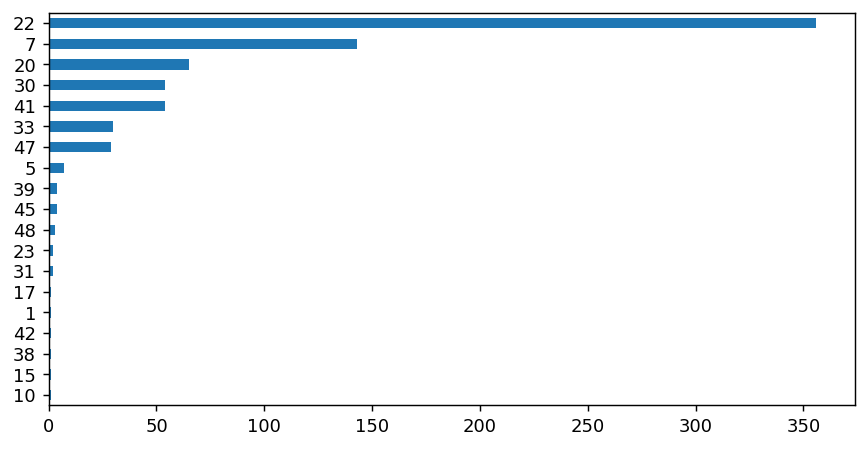

In [239]:
# Respondents by state
print('%s\n'%codebook['Q_US_state']['Q'])
fig,ax = plt.subplots(figsize=(8,4), dpi=130)
respondent_df['Q_US_state'].value_counts().sort_values().rename(
    codebook['Q_US_state']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_US_state'].value_counts().sort_values().rename(
    codebook['Q_US_state']['choices']))

Count the self-reported vegans and vegetarians and exclude them from analysis.


(For respondents who selected one option)
None           613
Vegetarian      43
Other           38
Pescatarian     20
Keto            13
Vegan            9
Gluten free      8
Name: Q_special_diet, dtype: int64


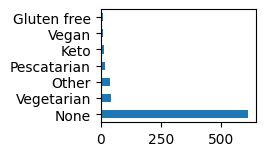

7          613
3           43
6           38
2           20
1           13
5            9
4            8
4,6          3
3,5          2
3,6          2
1,7          1
3,4          1
1,3,4        1
2,3          1
4,5          1
3,4,5,6      1
1,6          1
1,4          1
Name: Q_special_diet, dtype: int64


In [240]:
# '1':'Keto','2':'Pescatarian','3':'Vegetarian','4':'Gluten free','5':'Vegan','6':'Other','7':'None'
fig,ax = plt.subplots(figsize=(2,1.5), dpi=100)
# Not these value counts only include responses that selected one choice
print('(For respondents who selected one option)')
print(respondent_df.Q_special_diet.map(codebook['Q_special_diet']['choices']).value_counts())
respondent_df.Q_special_diet.map(codebook['Q_special_diet']['choices']).value_counts().plot.barh(ax=ax)
plt.show()
print(respondent_df['Q_special_diet'].value_counts())

Separate the vegan/vegetarian respondents from the others

In [241]:
respondent_df['is_vegetarian'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: 1 if ('3' in d) else 0)
respondent_df['is_vegan'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: 1 if ('5' in d) else 0)

veg_respondent_df = respondent_df[(respondent_df['is_vegetarian'] + respondent_df['is_vegan']) > 0]

print('total vegetarians and vegans (some overlap with participants reporting both): %s' % (len(veg_respondent_df)))
print('vegetarin: %s' % respondent_df['is_vegetarian'].sum())
print('vegan: %s' % respondent_df['is_vegan'].sum())

total vegetarians and vegans (some overlap with participants reporting both): 61
vegetarin: 51
vegan: 13


In [242]:
veg_N = len(veg_respondent_df)
print('Veg respondents N=%s' % veg_N)
(veg_respondent_df['Q_demos_gender']
 .astype(str)
 .map(codebook['Q_demos_gender']['choices'])
 .value_counts()
 .to_frame(name='n')
 .assign(pct=lambda x: round(100*x['n']/veg_N, 2)))

Veg respondents N=61


,n,pct
Female,44,72.13
Male,14,22.95
Other,3,4.92


In [243]:
len(respondent_df[(respondent_df['is_vegetarian'] < 1) & (respondent_df['is_vegan'] < 1)])

698

In [244]:
print('dropping vegans and vegetarians from main sample')
respondent_df = respondent_df[
    (respondent_df['is_vegetarian'] < 1) & (respondent_df['is_vegan'] < 1)
].drop(['is_vegan','is_vegetarian'], axis=1)
N = len(respondent_df)
print('resulting N=%s' % N)

dropping vegans and vegetarians from main sample
resulting N=698


In [245]:
"""
Make a table representing aggregate characteristics of the sample

characteristic, count or mean, (%) or (std) 
"""

sample_characteristics_cols = ['characteristic', 'count or mean', '(%) or (std)']
sample_aggregate_characteristics_df = pd.DataFrame({}, columns=sample_characteristics_cols)
sample_aggregate_characteristics_df

,characteristic,count or mean,(%) or (std)


                      count   (%)
gender                           
Female                  376  53.9
Male                    303  43.4
Other                    17   2.4
Prefer not to answer      2   0.3


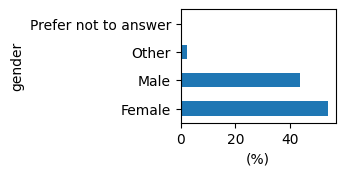

In [246]:
respondent_df['gender'] = respondent_df.Q_demos_gender.astype(str).map(codebook['Q_demos_gender']['choices'])
fig,ax = plt.subplots(figsize=(2,1.5),dpi=100)
gender_counts = respondent_df.groupby(
    'gender'
)['ResponseId'].count().rename('count').to_frame()
gender_counts['(%)'] = 100*round(gender_counts['count']/gender_counts['count'].sum(), 3)
print(gender_counts)
gender_counts['(%)'].plot.barh(ax=ax)
_ = ax.set_xlabel('(%)')

We code gender as a binary of male vs non-male

In [247]:
respondent_df['male'] = respondent_df['gender'].apply(lambda g: 1 if g =='Male' else 0)

In [248]:
gender_df = pd.DataFrame([
    ['Male',  respondent_df.male.sum(), round(100*respondent_df.male.sum()/N, 2)]],
    columns=sample_characteristics_cols,
)
sample_aggregate_characteristics_df = pd.concat([sample_aggregate_characteristics_df,gender_df])

How old are you?


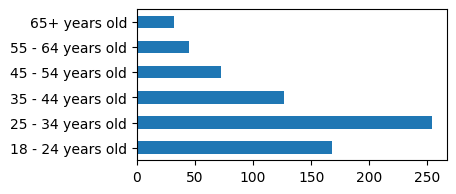

,index,count,pct
0,18 - 24 years old,168,24.07
1,25 - 34 years old,254,36.39
2,35 - 44 years old,127,18.19
3,45 - 54 years old,72,10.32
4,55 - 64 years old,45,6.45
5,65+ years old,32,4.58


In [249]:
print('%s'%codebook['Q_demos_age']['Q'])
fig,ax = plt.subplots(figsize=(4,2), dpi=100)
_ = respondent_df['Q_demos_age'].astype(str).value_counts().sort_index().rename(codebook['Q_demos_age']['choices']).plot.barh(ax=ax)
plt.show()
age_df = (respondent_df['Q_demos_age'].astype(str).value_counts()
          .sort_index().rename(codebook['Q_demos_age']['choices'])
          .to_frame(name='count').reset_index()
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
age_df

In [250]:
age_df.columns = sample_characteristics_cols
sample_aggregate_characteristics_df = pd.concat([
    sample_aggregate_characteristics_df, 
    pd.DataFrame([['Age', '','']], columns=sample_characteristics_cols),
    age_df
])

What was your total household income before taxes during the past 12 months?



,index,count,pct
0,"Less than $25,000",82,11.75
1,"\$25,000 to $49,999",143,20.49
2,"\$50,000 to $74,999",133,19.05
3,"\$75,000 to $99,999",120,17.19
4,"\$100,000 to $149,999",113,16.19
5,"\$150,000 or more",81,11.60
6,Prefer not to say,26,3.72


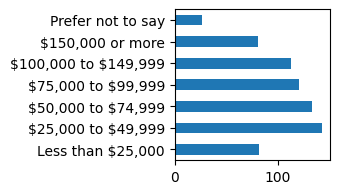

In [251]:
print('%s\n'%codebook['Q_demos_income']['Q'])
fig,ax = plt.subplots(figsize=(2,2), dpi=100)
_ = respondent_df['Q_demos_income'].astype(str).value_counts().sort_index().rename(
    codebook['Q_demos_income']['choices']).plot.barh(ax=ax)

income_df = (respondent_df['Q_demos_income'].astype(str).value_counts()
          .sort_index().rename(codebook['Q_demos_income']['choices'])
          .to_frame(name='count').reset_index()
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
income_df

In [252]:
income_df.columns = sample_characteristics_cols
sample_aggregate_characteristics_df = pd.concat([
    sample_aggregate_characteristics_df,
    pd.DataFrame([['Household income', '','']], columns=sample_characteristics_cols),
    income_df
])

Race

Note 2019 census estimates for MA have White alone at 80%

https://www.census.gov/quickfacts/MA

According to ACS 2018, White Americans are 80.7% of New England. [(From wikipedia)](https://en.wikipedia.org/wiki/Demographics_of_New_England#:~:text=In%20terms%20of%20race%20and,people%20of%20non%2DHispanic%20origin.)

,index,count,pct
0,White or Caucausian,569,81.52
1,Other,55,7.88
2,Asian,44,6.30
3,Black or African American,27,3.87
4,Native Hawaiian or Other Pacific Islander,2,0.29
5,American Indian/Native American or Alaska Native,1,0.14


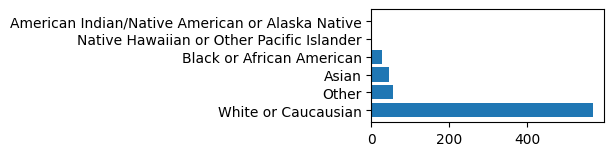

In [253]:
# Race: We put anyone who answered with 2 or more races or 'Prefer not to say' 
# in the 'Other' category
# print(respondent_df['Q_demos_race'].value_counts().sort_values())
respondent_df['race'] = (respondent_df['Q_demos_race']
                       .apply(lambda r: r if r in ['1','2','3','4','5'] else '6')
                       .map(codebook['Q_demos_race']['choices']))
race_df = (respondent_df['race'].value_counts().sort_values(ascending=False)
          .to_frame(name='count').reset_index()
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
fig,ax = plt.subplots(1,1,figsize=(3,1.5),dpi=100)
_ = ax.barh(race_df['index'], race_df['count'])
race_df

Which of the following best describes your political preference?
{'1': 'Strongly Democratic', '2': 'Democratic', '3': 'Lean Democratic', '4': 'Lean Republican', '5': 'Republican', '6': 'Strongly Republican'}


,count
Strongly Democratic,184
Democratic,201
Lean Democratic,185
Lean Republican,91
Republican,28
Strongly Republican,9


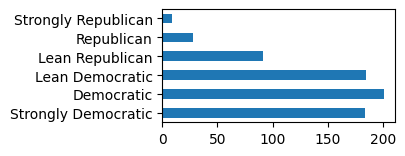

In [254]:
print('%s\n%s' % (codebook['Q_politics']['Q'], codebook['Q_politics']['choices']))
fig,ax = plt.subplots(figsize=(3,1.5),dpi=100)
respondent_df.Q_politics.astype(str).value_counts().sort_index().rename(
    codebook['Q_politics']['choices']).plot.barh(ax=ax)
respondent_df.Q_politics.astype(str).value_counts().sort_index().rename(
    codebook['Q_politics']['choices']).rename('count').to_frame()

Which best describes the area you live?


,count
Suburban,401
Urban,185
Rural,112


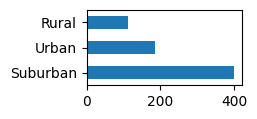

In [255]:
print(codebook['Q_live_urban']['Q'])
fig,ax = plt.subplots(figsize=(2,1),dpi=100)
respondent_df['Q_live_urban'].astype(str).value_counts().rename(
    codebook['Q_live_urban']['choices']).plot.barh(ax=ax)
respondent_df['Q_live_urban'].astype(str).value_counts().rename(
    codebook['Q_live_urban']['choices']).rename('count').to_frame()

Do you work in an urban area?


,count
No,412
Yes,264
Not sure / Other,22


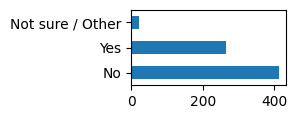

In [256]:
print(codebook['Q_work_urban']['Q'])
fig,ax = plt.subplots(figsize=(2,1),dpi=100)
respondent_df['Q_work_urban'].astype(str).value_counts().rename(
    codebook['Q_work_urban']['choices']).plot.barh(ax=ax)
respondent_df['Q_work_urban'].astype(str).value_counts().rename(
    codebook['Q_work_urban']['choices']).rename('count').to_frame()

How would you rank your current hunger level on a scale from 1 - 4?
1    132
2    278
3    228
4     60
Name: Q_current_hunger, dtype: int64


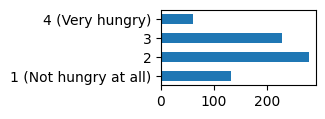

In [257]:
print(codebook['Q_current_hunger']['Q'])
fig,ax = plt.subplots(figsize=(2,1), dpi=100)
respondent_df['Q_current_hunger'].astype(str).value_counts().sort_index().rename(codebook['Q_current_hunger']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_current_hunger'].astype(str).value_counts().sort_index())

Transform (1-4) values from strings to integers

In [258]:
respondent_df['Q_current_hunger'] = respondent_df['Q_current_hunger'].astype(int)

In [259]:
sample_aggregate_characteristics_df = pd.concat([sample_aggregate_characteristics_df ,pd.DataFrame(
    [['Current hunger (1 - 4)', 
        respondent_df['Q_current_hunger'].mean(), 
        respondent_df['Q_current_hunger'].std()]],
    columns=sample_characteristics_cols
)])
# sample_aggregate_characteristics_df

In [260]:
print(codebook['Q_priorities']['Q'])
print(codebook['Q_priorities']['choices'])

How do you prioritize the following when choosing what to order for yourself off a menu?
{'1': 'Health', '2': 'Cost', '3': 'Taste', '4': 'Filling', '5': 'Usual choice'}


Transform from string to integer values

In [261]:
for p in codebook['Q_priorities']['choices'].keys():
    respondent_df['Q_priorities_%s'%p] = respondent_df['Q_priorities_%s'%p].astype(int)

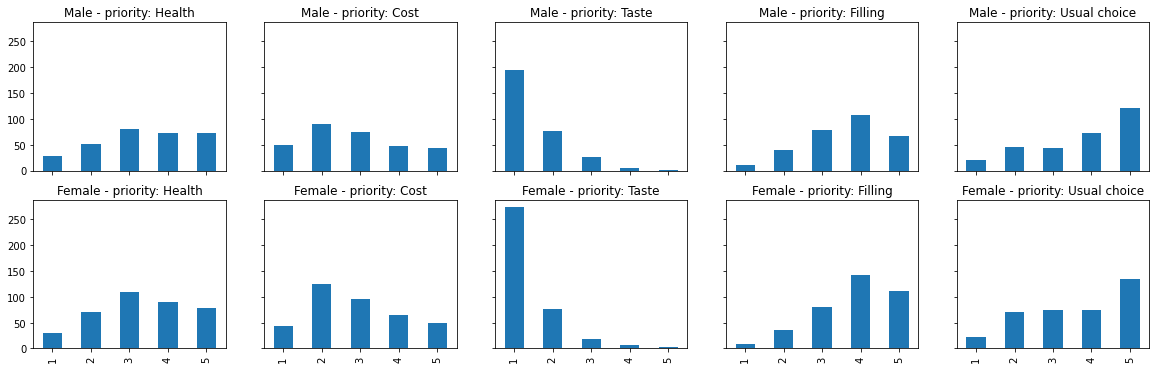

In [262]:
priorities_N = len(codebook['Q_priorities']['choices'])
fig, axes = plt.subplots(2, priorities_N, figsize=(4*priorities_N, 3*2), sharey=True, sharex=True)
for g, gender in enumerate(['Male','Female']):
    g_df = respondent_df[respondent_df['gender']==gender]
    for i, (p, priority) in enumerate(codebook['Q_priorities']['choices'].items()):
        Q_priority = 'Q_priorities_%s'%p
        ax = axes[g][i]
        ax.set_title('%s - priority: %s' % (gender, priority))
        g_df[Q_priority].value_counts().sort_index().plot.bar(ax=ax)

In [263]:
pkeys = list(codebook['Q_priorities']['choices'].keys())
priorities_df = pd.DataFrame({
    'priority': list(codebook['Q_priorities']['choices'].values()),
    'mean': [respondent_df['Q_priorities_%s'%p].mean() for p in pkeys],
    '(std)': [respondent_df['Q_priorities_%s'%p].std() for p in pkeys],
}, index=pkeys).sort_values('mean')
priorities_df

,priority,mean,(std)
3,Taste,1.434097,0.733957
2,Cost,2.829513,1.247501
1,Health,3.353868,1.235298
5,Usual choice,3.653295,1.311081
4,Filling,3.729226,1.050943


In [264]:
# priorities_df.columns = sample_characteristics_cols
# sample_aggregate_characteristics_df = pd.concat([
#     sample_aggregate_characteristics_df,
#     pd.DataFrame([['Relative importance when choosing off a menu', '','']], columns=sample_characteristics_cols),
#     priorities_df
# ])

How often does each priority occur as a top priority?

In [265]:
top_priority_df = (
    pd.DataFrame({
        'priority': list(codebook['Q_priorities']['choices'].values()),
        'count':[respondent_df['Q_priorities_%s'%p].apply(lambda p: p==1).sum() for p in pkeys],
    })
    .assign(pct=lambda x: round(100*x['count']/N, 2))
    .sort_values('pct', ascending=False)
)
top_priority_df

,priority,count,pct
2,Taste,475,68.05
1,Cost,100,14.33
0,Health,57,8.17
4,Usual choice,47,6.73
3,Filling,19,2.72


In [266]:
top_priority_df.columns = sample_characteristics_cols
sample_aggregate_characteristics_df = pd.concat([
    sample_aggregate_characteristics_df,
    pd.DataFrame([['Top priority when choosing off a menu', '','']], columns=sample_characteristics_cols),
    top_priority_df
])
# sample_aggregate_characteristics_df

In [267]:
print(codebook['Q_past_vegetarian']['Q'])
print(codebook['Q_past_vegan']['Q'])

In the past 7 days, on how many days did you have a meal that contained any meat, poultry, or fish?
In the past 7 days, on how many days did you eat a meal that contained any kind of animal product? (i.e. on how many days did you eat meat, poultry, fish, dairy, eggs, etc?)


In [268]:
respondent_df['Q_past_vegetarian'] = respondent_df['Q_past_vegetarian'].astype(int)
respondent_df['Q_past_vegan'] = respondent_df['Q_past_vegan'].astype(int)

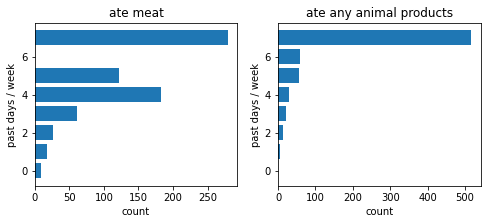

In [269]:
past_days_diet_df = respondent_df['Q_past_vegetarian'].value_counts().sort_index().rename('ate meat').to_frame()
past_days_diet_df.loc[6] = 0
past_days_diet_df = past_days_diet_df.sort_index()
past_days_diet_df.rename_axis('days/week')
past_days_diet_df['ate any animal products'] = respondent_df['Q_past_vegan'].value_counts().sort_index()
fig,axes = plt.subplots(1,2,figsize=(8,3))#, sharey=True)
axes[0].barh(past_days_diet_df.index, past_days_diet_df['ate meat'])
axes[1].barh(past_days_diet_df.index, past_days_diet_df['ate any animal products'])
axes[0].set_title('ate meat')
axes[1].set_title('ate any animal products')
axes[0].set_ylabel('past days / week')
axes[0].set_xlabel('count')
axes[1].set_ylabel('past days / week')
_ = axes[1].set_xlabel('count')
# past_days_diet_df

In [270]:
sample_aggregate_characteristics_df = pd.concat([
    sample_aggregate_characteristics_df,
    pd.DataFrame([
        ['Past days/week ate meet', respondent_df['Q_past_vegetarian'].mean(), respondent_df['Q_past_vegetarian'].std()],
        ['Past days/week ate any animal products', respondent_df['Q_past_vegan'].mean(), respondent_df['Q_past_vegan'].std()]
    ], columns=sample_characteristics_cols)
])

How strongly do you agree with the following statement?
"Vegan dishes are not for people like me."



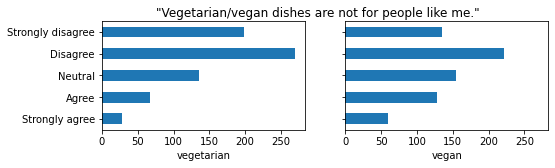

In [271]:
print('%s\n'%codebook['Q_vegan_not_me']['Q'])
fig,axes = plt.subplots(1,2,figsize=(8,2),sharey=True,sharex=True)
fig.suptitle('"Vegetarian/vegan dishes are not for people like me."')
respondent_df['Q_vegetarian_not_me'].astype(str).value_counts().sort_index().rename(
    codebook['Q_vegetarian_not_me']['choices']).plot.barh(ax=axes[0])
axes[0].set_xlabel("vegetarian")
respondent_df['Q_vegan_not_me'].astype(str).value_counts().sort_index().rename(
    codebook['Q_vegan_not_me']['choices']).plot.barh(ax=axes[1])
_ = axes[1].set_xlabel("vegan")

In [272]:
def collapse_categories_5_to_3(resp):
    """Maps 5 point scale to 3 point scale: Maps 1-2 -> 1; 3 -> 2; 3-4 -> 3"""
    if resp < 3:
        return 1
    if resp == 3:
        return 2
    return 3

reduced_agree_neutral_disagree_map = {
    1: 'Strongly agree or agree',
    2: 'Neutral',
    3: 'Disagree or strongly disagree'
}
def map_agree_neutral_disagree(resp):
    return reduced_agree_neutral_disagree_map[resp]

reduced_importance_map = {
    1: 'Not important',
    2: 'Neutral',
    3: 'Important'
}

In [273]:
vegetarian_not_me_df = (
    respondent_df['Q_vegetarian_not_me']
    .astype(int)
    .apply(collapse_categories_5_to_3)
    .apply(map_agree_neutral_disagree)
    .value_counts()
    .reindex(reduced_agree_neutral_disagree_map.values())
    .to_frame(name='count').reset_index()
    .assign(pct=lambda x: round(100*x['count']/N, 2))
)
vegetarian_not_me_df.columns = sample_characteristics_cols
vegetarian_not_me_df

,characteristic,count or mean,(%) or (std)
0,Strongly agree or agree,95,13.61
1,Neutral,135,19.34
2,Disagree or strongly disagree,468,67.05


In [274]:
vegan_not_me_df = (
    respondent_df['Q_vegan_not_me']
    .astype(int)
    .apply(collapse_categories_5_to_3)
    .apply(map_agree_neutral_disagree)
    .value_counts()
    .reindex(reduced_agree_neutral_disagree_map.values())
    .to_frame(name='count').reset_index()
    .assign(pct=lambda x: round(100*x['count']/N, 2))
)
vegan_not_me_df.columns = sample_characteristics_cols
vegan_not_me_df

,characteristic,count or mean,(%) or (std)
0,Strongly agree or agree,188,26.93
1,Neutral,154,22.06
2,Disagree or strongly disagree,356,51.00


In [275]:
sample_aggregate_characteristics_df = pd.concat([
    sample_aggregate_characteristics_df,
    pd.DataFrame([['"Vegetarian dishes are not for people like me."', '','']], columns=sample_characteristics_cols),
    vegetarian_not_me_df,
    pd.DataFrame([['"Vegan dishes are not for people like me."', '','']], columns=sample_characteristics_cols),
    vegan_not_me_df,
])

How strongly do you agree with the following statement?
"Vegetarian and vegan dishes are good for the environment."

Strongly agree       151
Agree                325
Neutral              197
Disagree              17
Strongly disagree      8
Name: Q_good_for_env, dtype: int64


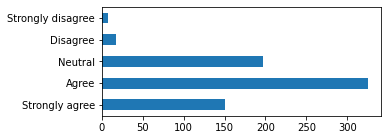

In [276]:
print('%s\n'%codebook['Q_good_for_env']['Q'])
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_good_for_env'].astype(str).value_counts().sort_index().rename(codebook['Q_good_for_env']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_good_for_env'].astype(str).value_counts().sort_index().rename(codebook['Q_good_for_env']['choices']))

How important is environmental sustainability to you as an issue?
Very much not important     21
Not important               37
Neutral                     71
Somewhat important         319
Very important             250
Name: Q_how_important_env, dtype: int64


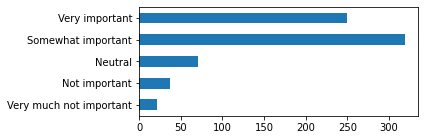

In [277]:
print(codebook['Q_how_important_env']['Q'])
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_how_important_env'].astype(str).value_counts().sort_index().rename(codebook['Q_how_important_env']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_how_important_env'].astype(str).value_counts().sort_index().rename(codebook['Q_how_important_env']['choices']))

In [278]:
sample_aggregate_characteristics_df['(%) or (std)'] = (
    sample_aggregate_characteristics_df['(%) or (std)']
    .apply(lambda x: round(x,2) if x != '' else x)
)
sample_aggregate_characteristics_df['count or mean'] = (
    sample_aggregate_characteristics_df['count or mean']
    .apply(lambda x: round(x,2) if x != '' else x)
)
sample_aggregate_characteristics_df

,characteristic,count or mean,(%) or (std)
0,Male,303,43.41
0,Age,,
0,18 - 24 years old,168,24.07
1,25 - 34 years old,254,36.39
2,35 - 44 years old,127,18.19
3,45 - 54 years old,72,10.32
4,55 - 64 years old,45,6.45
5,65+ years old,32,4.58
0,Household income,,
0,"Less than $25,000",82,11.75


In [279]:
# Format it for Latex
def formatted_count_mean(row):
    if not row['count or mean']: return ''
    is_pct = not any([s in row['characteristic'] for s in ['Past days/week', 'Current hunger']])
    return ('%s (%s%s)' % (row['count or mean'], row['(%) or (std)'], '%' if is_pct else ''))

sample_aggregate_characteristics_df['count (%) or mean (SD)'] = \
    sample_aggregate_characteristics_df.apply(formatted_count_mean, axis=1)
sample_aggregate_characteristics_df[['characteristic', 'count (%) or mean (SD)']]

,characteristic,count (%) or mean (SD)
0,Male,303 (43.41%)
0,Age,
0,18 - 24 years old,168 (24.07%)
1,25 - 34 years old,254 (36.39%)
2,35 - 44 years old,127 (18.19%)
3,45 - 54 years old,72 (10.32%)
4,55 - 64 years old,45 (6.45%)
5,65+ years old,32 (4.58%)
0,Household income,
0,"Less than $25,000",82 (11.75%)


In [280]:
print(sample_aggregate_characteristics_df[
    ['characteristic', 'count (%) or mean (SD)']
].to_latex(index=False))

\begin{tabular}{ll}
\toprule
                                 characteristic & count (\%) or mean (SD) \\
\midrule
                                           Male &           303 (43.41\%) \\
                                            Age &                        \\
                              18 - 24 years old &           168 (24.07\%) \\
                              25 - 34 years old &           254 (36.39\%) \\
                              35 - 44 years old &           127 (18.19\%) \\
                              45 - 54 years old &            72 (10.32\%) \\
                              55 - 64 years old &             45 (6.45\%) \\
                                  65+ years old &             32 (4.58\%) \\
                               Household income &                        \\
                              Less than \$25,000 &            82 (11.75\%) \\
                            \textbackslash \$25,000 to \$49,999 &           143 (20.49\%) \\
                       

More correlations between covariates

In [281]:
def styled_boxplot(df, by, column=None, ax=None):
    df.boxplot(
        column=column,
        by=by, ax=ax,
        grid=False,
        vert=False,
        showmeans=True,
        meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick'),
        boxprops=dict(linestyle='-', linewidth=1.5),
        flierprops=dict(linestyle='-', linewidth=1.5),
        medianprops=dict(linestyle='-', linewidth=2, color='firebrick'),
        whiskerprops=dict(linestyle='-', linewidth=1.5),
        #capprops=dict(linestyle='-', linewidth=1.5),
        showfliers=False,
        rot=0
    ).get_figure().suptitle('') # remove title automatically added by pandas

/Users/aberke/projects/ff/venv-ff/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator


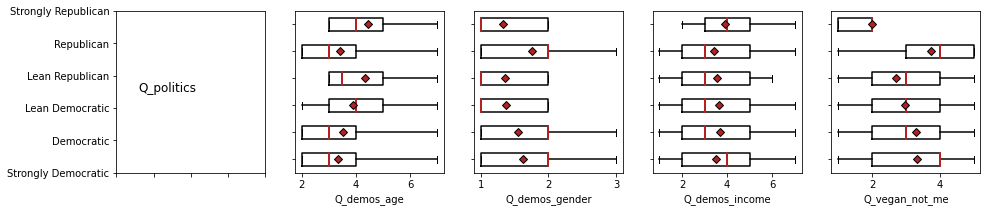

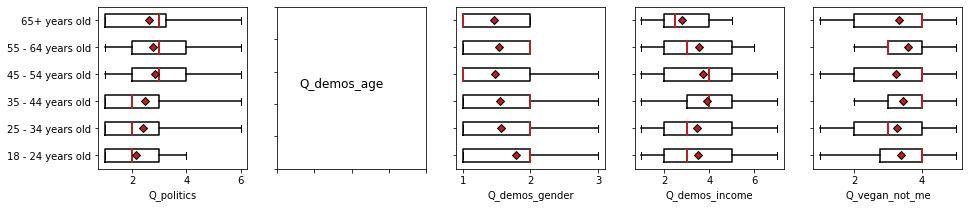

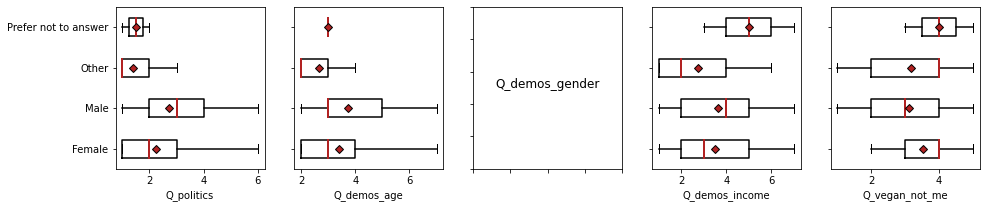

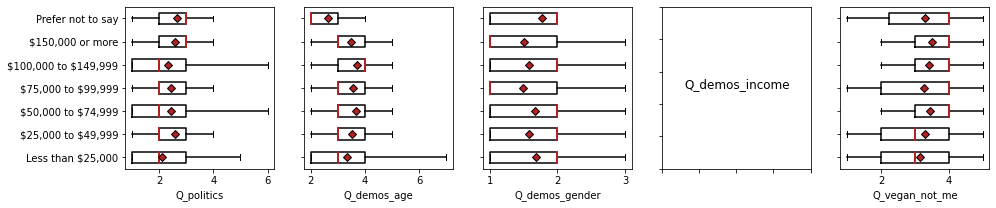

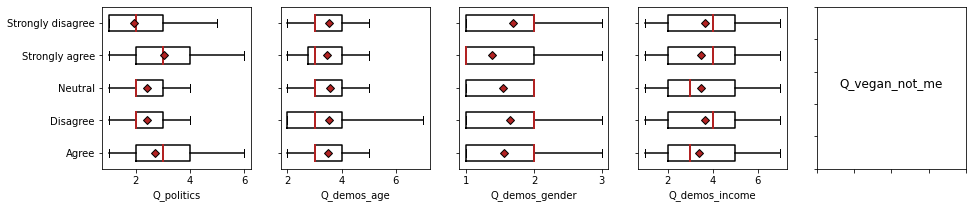

In [282]:
# Covariates correlations
cc_list = [
    'Q_politics', 
    'Q_demos_age', 
    'Q_demos_gender', 
    'Q_demos_income',
    'Q_vegan_not_me',
    
]
# make a df for analysis
df = respondent_df[cc_list].copy().astype(str)


alt_map = ['Q_demos_income']
n_ccs = len(cc_list)


for i in range(n_ccs):
    fig, axes = plt.subplots(1,n_ccs, figsize=(3*n_ccs,3),
                             facecolor='w', edgecolor='k')
    for j in range(n_ccs):
        ax = axes[j]
        cc_i = cc_list[i]
        cc_j = cc_list[j]
        if i == j:
            if i == 0:
                ax.set_yticklabels(list(codebook[cc_i]['choices'].values()))
            else:
                ax.set_yticklabels([])
            ax.text(0.15, 0.5, cc_i, fontsize = 12)
            ax.set_xticklabels([])
            continue
        rdf = df[[cc_i, cc_j]].copy()
        if cc_i not in alt_map:
            rdf[cc_i] = rdf[cc_i].map(codebook[cc_i]['choices'])
        rdf[cc_j] = rdf[cc_j].astype(float)
        styled_boxplot(rdf, by=cc_i, column=cc_j, ax=ax)
        if j > 0:
            ax.set_yticklabels([])
        if (cc_i in alt_map) and (j==0):
            ax.set_yticklabels(codebook[cc_i]['choices'].values())
        ax.set_xlabel(cc_j)
        ax.set_title('')
        # ax.set_title('%s' % (cc_j))

### Menu choices table

```
ResponseId, labeled (0/1), QID, choice_type (1-5), choice (1/0) 
```

In [295]:
# choices_df excludes vegetarian/vegan respondents.
# veg_choices_df only includes them.

# Wide data
choices_wide_df = survey_df[['ResponseId'] + choice_Qs]
# Drop data from respondents who failed attention checks or are veg
choices_wide_df = choices_wide_df[
    (choices_wide_df.ResponseId.isin(respondent_df['ResponseId']))
]
choices_wide_df.head(3)
assert(len(respondent_df) == len(choices_wide_df))

In [296]:
# Create a separate dataframe for respondents who are veg
# Start wide wide data
veg_choices_wide_df = survey_df[['ResponseId'] + choice_Qs]
# Drop data from respondents who failed attention; keep only veg
veg_choices_wide_df = veg_choices_wide_df[
    (veg_choices_wide_df.ResponseId.isin(veg_respondent_df['ResponseId']))
]
assert(len(veg_respondent_df) == len(veg_choices_wide_df))

In [297]:
def transform_choices_data(wide_df):
    # Transform from wide to long data
    choices_df = pd.melt(wide_df, id_vars=['ResponseId'], value_vars=choice_Qs, 
                 var_name='QID', value_name='choice')
    # Add Q data
    # ResponseId, labeled (0/1), QID, choice_type (1-5), choice (1/0)
    # code choice, choice_type, labeled as numeric
    choices_df['choice_type'] = choices_df['QID'].apply(lambda QID: int(QID.split('_')[2]))
    choices_df['labeled'] = choices_df['QID'].apply(lambda QID: 1 if len(QID.split('_')) > 3 and QID.split('_')[3] == 'labeled' else 0)
    # only keep responses for answered questions
    # this should equal half of the total questions
    assert(0.5 == len(choices_df.dropna())/len(choices_df))
    choices_df = choices_df.dropna()
    choices_df['choice'] = choices_df['choice'].astype(int)
    return choices_df

In [298]:
choices_df = transform_choices_data(choices_wide_df)
choices_df.head()

,ResponseId,QID,choice,choice_type,labeled
1,R_23V4Eyckqxl6Bmy,Q_sandwich_1,0,1,0
3,R_2B97XuOwuxSeQWA,Q_sandwich_1,0,1,0
5,R_1DBZC4pjzVDsgT6,Q_sandwich_1,0,1,0
8,R_2SdGAfdbJx8Aq5C,Q_sandwich_1,0,1,0
11,R_2xL9vHDm0KfOgCa,Q_sandwich_1,0,1,0


In [299]:
# transform to long data
veg_choices_df = transform_choices_data(veg_choices_wide_df)
assert(len(veg_choices_df) == len(veg_respondent_df) * 5) # 5 Qs per respondent
veg_choices_df.head(3)

,ResponseId,QID,choice,choice_type,labeled
1,R_db759QXvWIY4clr,Q_sandwich_1,1,1,0
8,R_1erxzxxDxVFbdhm,Q_sandwich_1,1,1,0
10,R_1rjfMCE36BveJbP,Q_sandwich_1,1,1,0


Choices data

In [301]:
choices_df.head()

,ResponseId,QID,choice,choice_type,labeled
1,R_23V4Eyckqxl6Bmy,Q_sandwich_1,0,1,0
3,R_2B97XuOwuxSeQWA,Q_sandwich_1,0,1,0
5,R_1DBZC4pjzVDsgT6,Q_sandwich_1,0,1,0
8,R_2SdGAfdbJx8Aq5C,Q_sandwich_1,0,1,0
11,R_2xL9vHDm0KfOgCa,Q_sandwich_1,0,1,0


### Respondent level variables

gender

In [302]:
# Coding male as Male: 1; Otherwise: 0
choices_df['male'] = choices_df['ResponseId'].map(
    respondent_df.set_index('ResponseId')['gender']
).apply(lambda g: 1 if g=='Male' else 0)

Other basic demographics to control for

In [303]:
choices_df['age'] = choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['Q_demos_age']).astype(str)
choices_df['income'] = choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['Q_demos_income']).astype(str)

In [304]:
choices_df.head(4)

,ResponseId,QID,choice,choice_type,labeled,male,age,income
1,R_23V4Eyckqxl6Bmy,Q_sandwich_1,0,1,0,1,7,5
3,R_2B97XuOwuxSeQWA,Q_sandwich_1,0,1,0,1,4,2
5,R_1DBZC4pjzVDsgT6,Q_sandwich_1,0,1,0,1,5,5
8,R_2SdGAfdbJx8Aq5C,Q_sandwich_1,0,1,0,1,5,4


##### Veg choices data

For the vegetarian choices data, add in who is vegan vs vegetarian so that can properly test choice type 5.

In [305]:
for is_v in ['is_vegetarian', 'is_vegan']:
    veg_choices_df[is_v] = veg_choices_df.ResponseId.map(veg_respondent_df.set_index('ResponseId')[is_v])
veg_choices_df.head(3)

,ResponseId,QID,choice,choice_type,labeled,is_vegetarian,is_vegan
1,R_db759QXvWIY4clr,Q_sandwich_1,1,1,0,1,0
8,R_1erxzxxDxVFbdhm,Q_sandwich_1,1,1,0,1,1
10,R_1rjfMCE36BveJbP,Q_sandwich_1,1,1,0,1,0


## Analysis

### Plots and Chi-Square tests and odds ratios

In [300]:
choices_type_names_dict = {
    1:'1=(labeled) vegetarian vs 0=meat',
    2:'1=(labeled) vegan vs 0=meat',
    3:'1=(labeled) vegetarian vs 0=vegetarian',
    4:'1=(labeled) vegan vs 0=vegan',
    5:'1=(labeled) vegan vs 0=vegetarian',
}

In [307]:
# For plotting
plot_choices_type_names_dict = {
    1:'(1) vegetarian vs (2) meat',
    2:'(1) vegan vs (2) meat',
    3:'(1) vegetarian vs (2) vegetarian',
    4:'(1) vegan vs (2) vegan',
    5:'(1) vegan vs (2) vegetarian',
}

In [308]:
# https://zepid.readthedocs.io/en/latest/Reference/generated/zepid.base.OddsRatio.html
from zepid import OddsRatio

In [309]:
def make_contingency_df(df):
    """
    Make tables like:
    ```
    choice, labeled, unlabeled, (%) labeled, (%) unlabeled, expected (based on unlabeled)
    0    A           B
    1    C           D
    total
    ```
    """
    contingency_df = pd.DataFrame({
        'labeled': df[df['labeled']==1]['choice'].value_counts(),
        'unlabeled': df[df['labeled']==0]['choice'].value_counts(),
    }, index=[0, 1]).rename_axis('choice').fillna(0)
    contingency_df.loc['total'] = [contingency_df[c].sum() for c in contingency_df.columns]
    for l in ['labeled', 'unlabeled']:
        contingency_df['fraction %s'%l] = contingency_df[l]/contingency_df[l]['total']
        contingency_df['%% %s'%l] = round(100*contingency_df['fraction %s'%l],2)
    contingency_df['expected'] = (
        contingency_df['labeled']['total'] * contingency_df['fraction unlabeled']
    )
    return contingency_df.drop(['fraction labeled','fraction unlabeled'],axis=1)

In [310]:
choices_all_contingency_df = make_contingency_df(choices_df)
choices_all_contingency_df

,labeled,unlabeled,% labeled,% unlabeled,expected
choice,,,,,
0,1145,1121,66.57,63.33,1089.333333
1,575,649,33.43,36.67,630.666667
total,1720,1770,100.00,100.00,1720.000000


In [311]:
def plot_contingency_table(df, ax, legend_labels=['option 2','(v) option 1'], ylabel=True, legend=True):
    n_labels_values = df.loc['total'][['labeled', 'unlabeled']]
    labels = ['%s\n(n=%s)'%(l, int(n)) for l, n in n_labels_values.iteritems()]
    #labels = ['labeled', 'unlabeled'] # a simpler labeling
    option1_values = df[['% labeled', '% unlabeled']].loc[1]
    option2_values = df[['% labeled', '% unlabeled']].loc[0]

    x = np.arange(len(labels))  # the label locations
    width = 0.45  # the width of the bars
    rects1 = ax.bar(x - width/2, option1_values, width, 
                    linewidth=1, edgecolor='black',
                    color='lightgray', label=legend_labels[1])
    rects2 = ax.bar(x + width/2, option2_values, width, 
                    linewidth=1, edgecolor='black',
                    color='white', label=legend_labels[0])
    ax.set_ylim(0, 108)
    if ylabel: ax.set_ylabel('% chosen')
    ax.set_xticks(x, labels)
    option1_labels = ['%0.1f%%'%v for v in round(option1_values, 1)]
    option2_labels = ['%0.1f%%'%v for v in round(option2_values, 1)]
    ax.bar_label(rects1, option1_labels, padding=3)
    ax.bar_label(rects2, option2_labels, padding=3)
    if legend: ax.legend()

In [312]:
def print_OR(choices_df, plot=False):
    ort = OddsRatio()
    ort.fit(choices_df, exposure='labeled',outcome='choice')
    if plot:
        fig,ax = plt.subplots(figsize=(2,1))
        _ = ort.plot()
    print(ort.summary())

Odds ratio:
Comparison:0 to 1
+-----+-------+-------+
|     |   D=1 |   D=0 |
+=====+=======+=======+
| E=1 |   575 |  1145 |
+-----+-------+-------+
| E=0 |   649 |  1121 |
+-----+-------+-------+ 

                           Odds Ratio                                 
       OddsRatio  SD(OR)  OR_LCL  OR_UCL
Ref:0      1.000     NaN     NaN     NaN
1          0.867   0.071   0.755   0.997
----------------------------------------------------------------------
Missing E:    0
Missing D:    0
Missing E&D:  0
None


N=3490; chisq = 7.758; p=0.005


,labeled,unlabeled,% labeled,% unlabeled,expected
choice,,,,,
0,1145,1121,66.57,63.33,1089.333333
1,575,649,33.43,36.67,630.666667
total,1720,1770,100.00,100.00,1720.000000


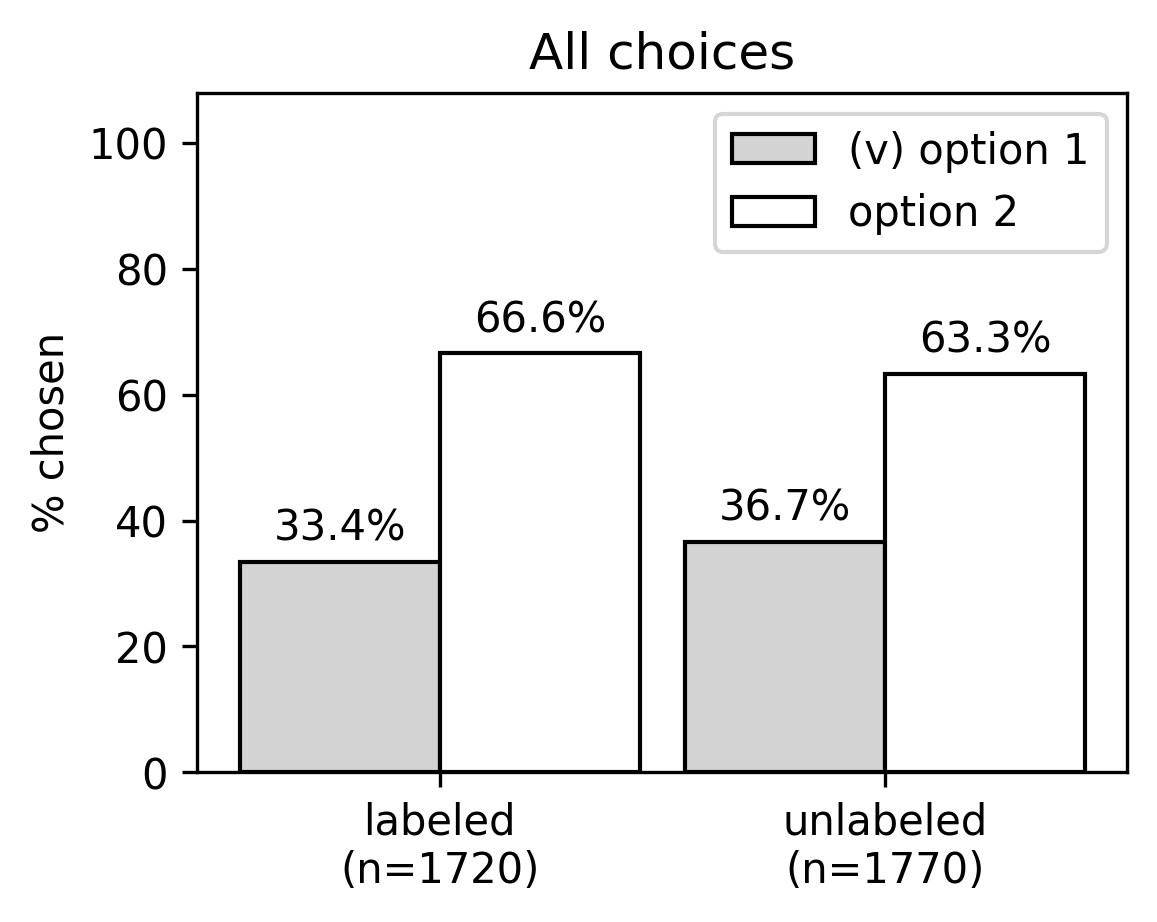

In [313]:
print('Odds ratio:')
print_OR(choices_df)
figsize=(4,3)
fig,ax = plt.subplots(figsize=figsize, dpi=300)
plot_contingency_table(choices_all_contingency_df, ax)
chisq, p = scipy.stats.chisquare(
    choices_all_contingency_df['labeled'].drop('total'),
    choices_all_contingency_df['expected'].drop('total'), 
)
print('\n\nN=%s; chisq = %0.3f; p=%0.3f' % (len(choices_df),chisq,p))
ax.set_title('All choices')
choices_all_contingency_df

Plot choice 5 only

Odds ratio:
Comparison:0 to 1
+-----+-------+-------+
|     |   D=1 |   D=0 |
+=====+=======+=======+
| E=1 |   127 |   217 |
+-----+-------+-------+
| E=0 |   151 |   203 |
+-----+-------+-------+ 

                           Odds Ratio                                 
       OddsRatio  SD(OR)  OR_LCL  OR_UCL
Ref:0      1.000     NaN     NaN     NaN
1          0.787   0.155   0.581   1.066
----------------------------------------------------------------------
Missing E:    0
Missing D:    0
Missing E&D:  0
None


N=698; chisq = 4.628; p=0.031


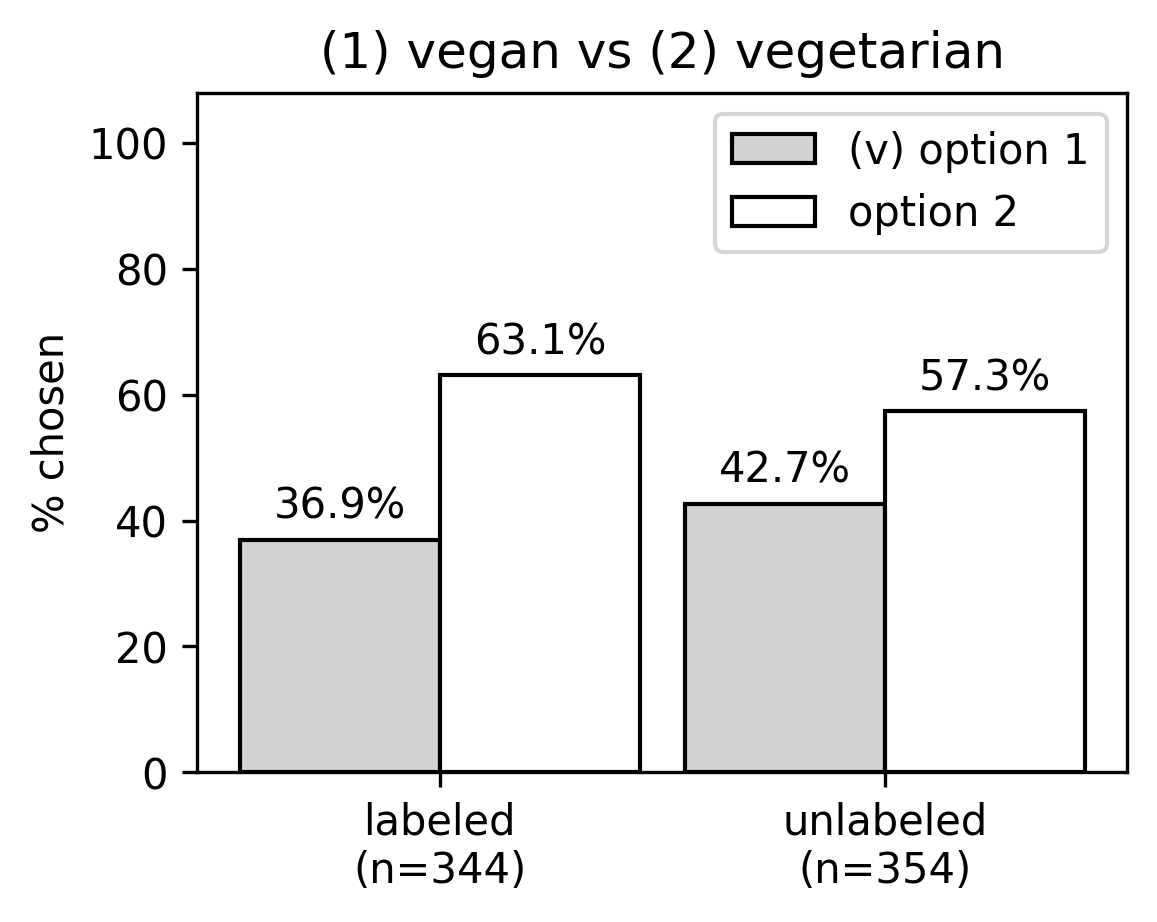

,labeled,unlabeled,% labeled,% unlabeled,expected
choice,,,,,
0,217,203,63.08,57.34,197.265537
1,127,151,36.92,42.66,146.734463
total,344,354,100.00,100.00,344.000000


In [314]:
c5df = choices_df[choices_df['choice_type']==5]
print('Odds ratio:')
print_OR(c5df)

c5_contingency_df = make_contingency_df(c5df)
chisq, p = scipy.stats.chisquare(
    c5_contingency_df['labeled'].drop('total'), 
    c5_contingency_df['expected'].drop('total'),
)
fig,ax = plt.subplots(figsize=figsize,dpi=300)
plot_contingency_table(c5_contingency_df, ax)
print('\n\nN=%s; chisq = %0.3f; p=%0.3f' % (len(c5df),chisq, p))
ax.set_title('%s'%(plot_choices_type_names_dict[5]))
plt.show()
c5_contingency_df

Plots and tables for all choice types separately

1: (1) vegetarian vs (2) meat
chisq = 7.908; p=0.005


,labeled,unlabeled,% labeled,% unlabeled,expected
choice,,,,,
0,253,235,73.55,66.38,228.361582
1,91,119,26.45,33.62,115.638418
total,344,354,100.00,100.00,344.000000


2: (1) vegan vs (2) meat
chisq = 0.123; p=0.726


,labeled,unlabeled,% labeled,% unlabeled,expected
choice,,,,,
0,239,249,69.48,70.34,241.966102
1,105,105,30.52,29.66,102.033898
total,344,354,100.00,100.00,344.000000


3: (1) vegetarian vs (2) vegetarian
chisq = 0.378; p=0.539


,labeled,unlabeled,% labeled,% unlabeled,expected
choice,,,,,
0,251,253,72.97,71.47,245.853107
1,93,101,27.03,28.53,98.146893
total,344,354,100.00,100.00,344.000000


4: (1) vegan vs (2) vegan
chisq = 0.966; p=0.326


,labeled,unlabeled,% labeled,% unlabeled,expected
choice,,,,,
0,185,181,53.78,51.13,175.887006
1,159,173,46.22,48.87,168.112994
total,344,354,100.00,100.00,344.000000


5: (1) vegan vs (2) vegetarian
chisq = 4.628; p=0.031


,labeled,unlabeled,% labeled,% unlabeled,expected
choice,,,,,
0,217,203,63.08,57.34,197.265537
1,127,151,36.92,42.66,146.734463
total,344,354,100.00,100.00,344.000000


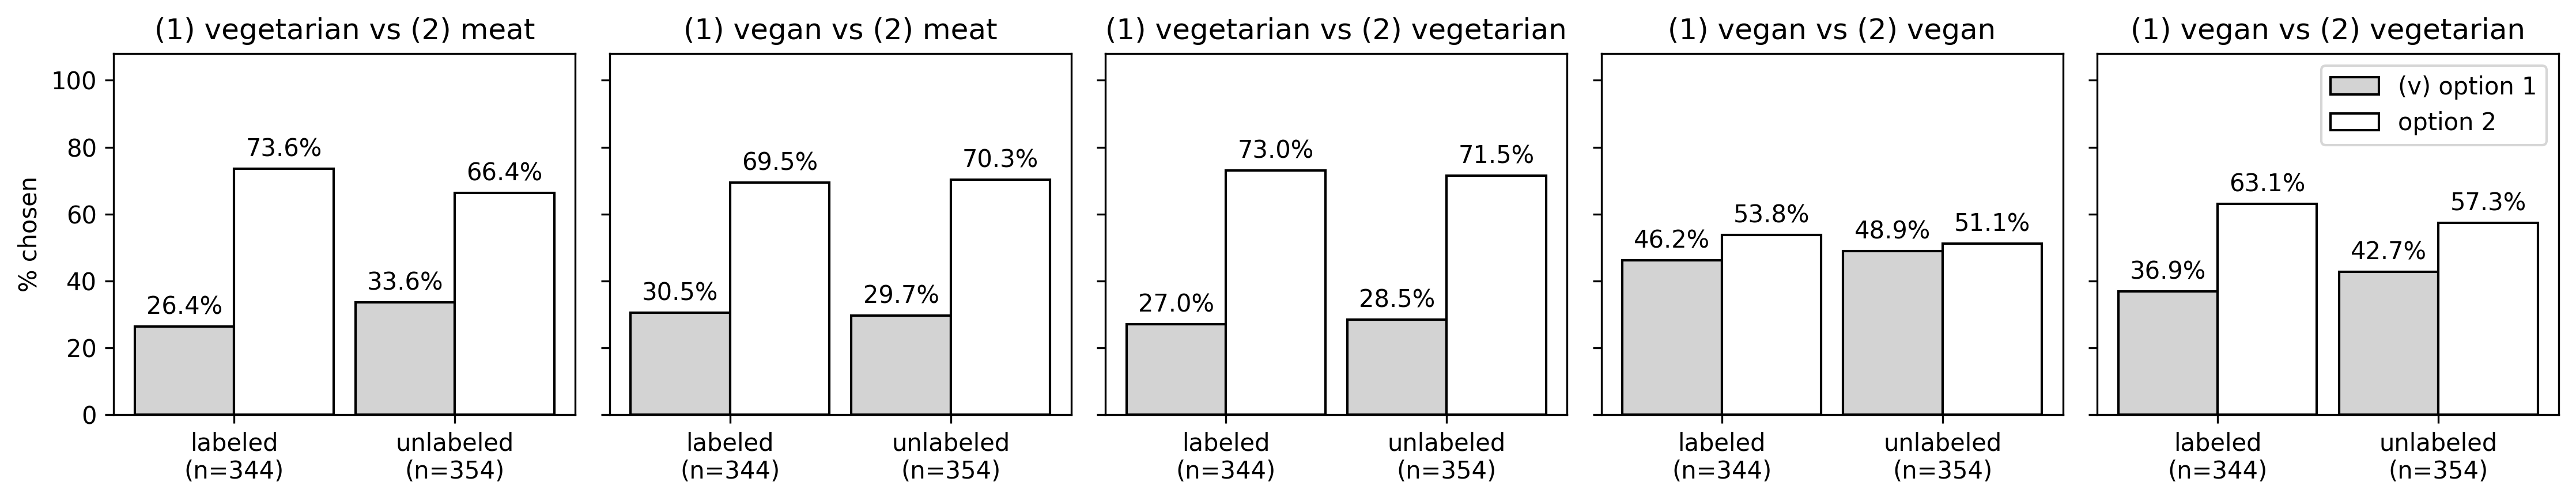

In [337]:
ncols=len(plot_choices_type_names_dict)
fig,axes = plt.subplots(
    1, ncols, figsize=(3*ncols,3),
    sharey=True,
    dpi=300, 
    facecolor='white'
)
for i, (choice_type, name) in enumerate(plot_choices_type_names_dict.items()):
    print('%s: %s' % (choice_type, name))
    cdf = choices_df[choices_df['choice_type']==choice_type]
    c_contingency_df = make_contingency_df(cdf)
    chisq, p = scipy.stats.chisquare(
        c_contingency_df['labeled'].drop('total'), 
        c_contingency_df['expected'].drop('total')
    )
    print('chisq = %0.3f; p=%0.3f' % (chisq, p))
    display(c_contingency_df)
    ax = axes[i]
    ylabel = False if i > 0 else True
    legend = False if i < 4 else True
    plot_contingency_table(c_contingency_df, ax, ylabel=ylabel, legend=legend)
    ax.set_title('%s'%(name,))
fig.tight_layout()
plt.show()

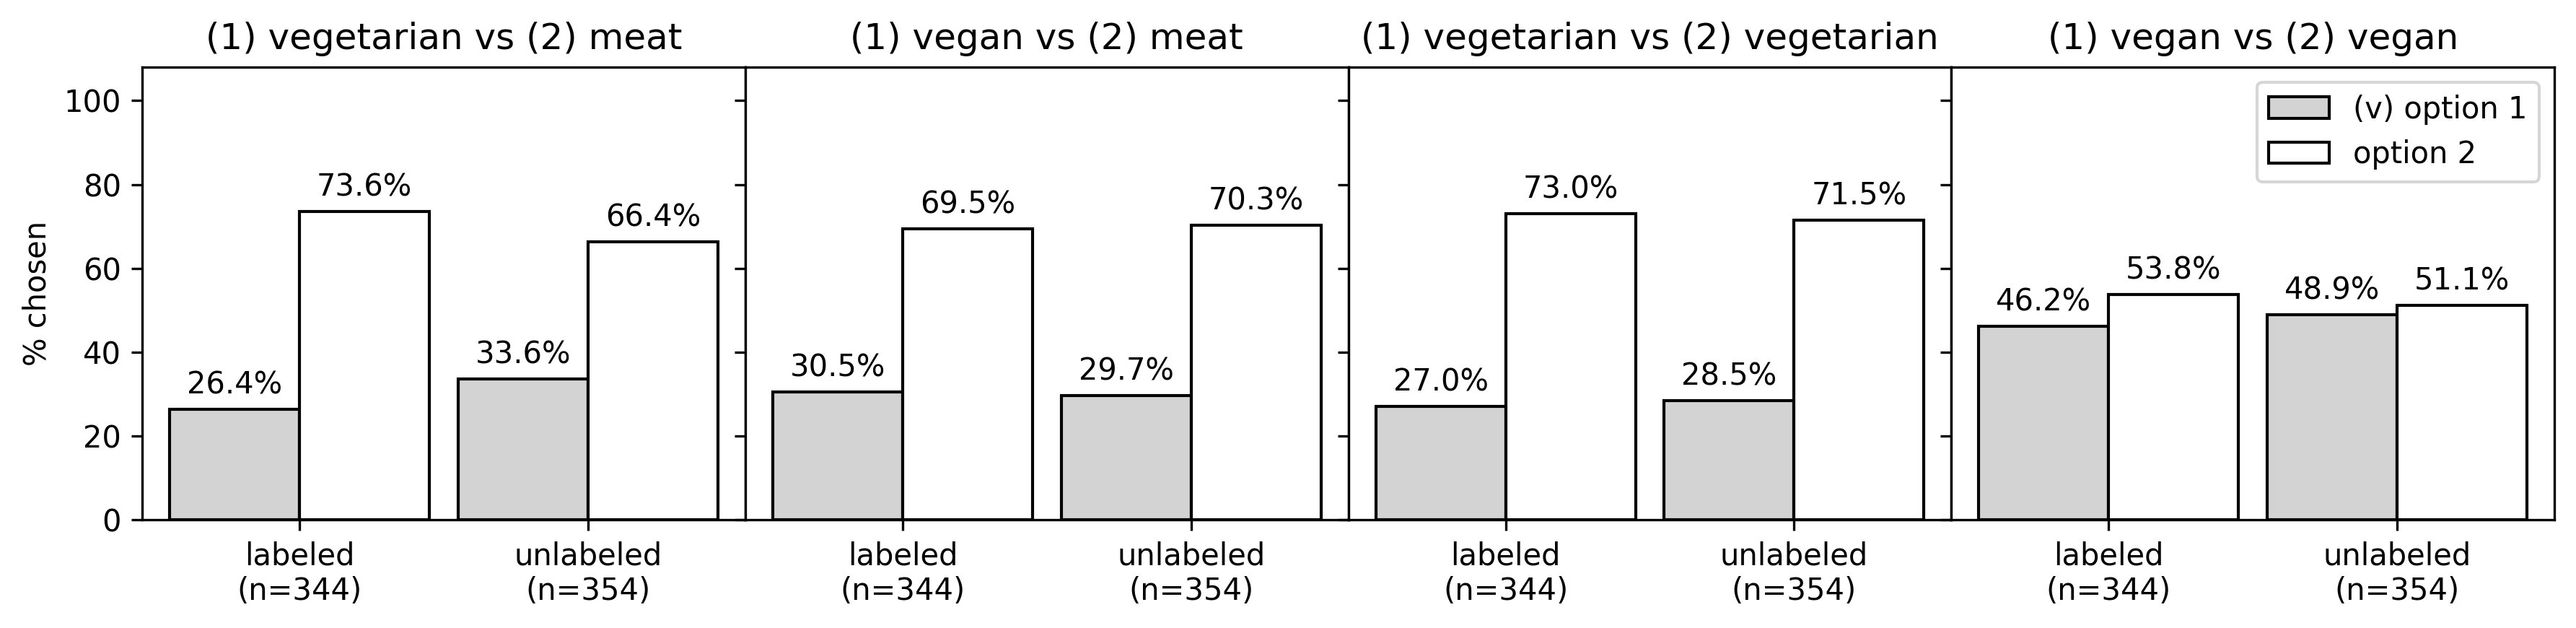

In [321]:
ncols=len(plot_choices_type_names_dict)-1
fig,axes = plt.subplots(
    1, ncols, figsize=(3*ncols,3),
    sharey=True,
    dpi=300, 
    facecolor='white'
)
for i, (choice_type, name) in enumerate(plot_choices_type_names_dict.items()):
    if i >= ncols: break
    #print('%s: %s' % (choice_type, name))
    cdf = choices_df[choices_df['choice_type']==choice_type]
    c_contingency_df = make_contingency_df(cdf)
    chisq, p = scipy.stats.chisquare(
        c_contingency_df['labeled'].drop('total'), 
        c_contingency_df['expected'].drop('total')
    )
    #print('chisq = %0.3f; p=%0.3f' % (chisq, p))
    #display(c_contingency_df)
    ax = axes[i]
    ylabel = False if i > 0 else True
    legend = True if i == (ncols-1) else False
    plot_contingency_table(c_contingency_df, ax, ylabel=ylabel, legend=legend)
    ax.set_title('%s'%(name,))
fig.tight_layout()
plt.subplots_adjust(wspace=0)
plt.show()

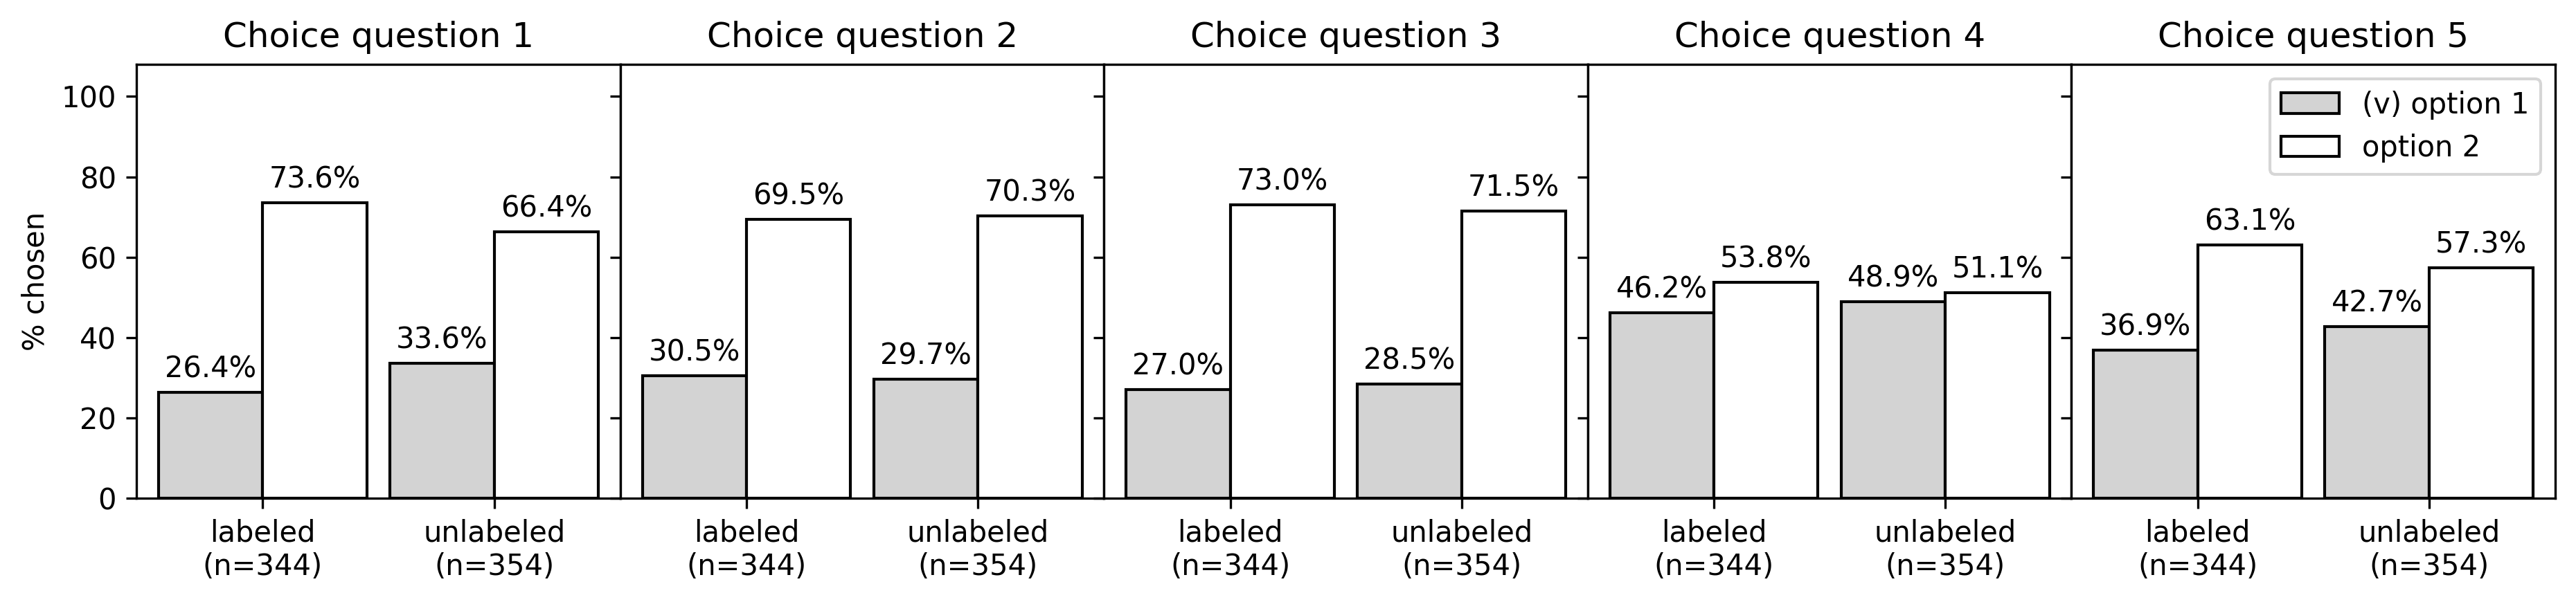

In [318]:
ncols=len(plot_choices_type_names_dict)
fig,axes = plt.subplots(
    1, ncols, figsize=(2.5*ncols,3),
    sharey=True,
    dpi=300, 
    facecolor='white'
)
for i, (choice_type, name) in enumerate(plot_choices_type_names_dict.items()):
    #print('%s: %s' % (choice_type, name))
    cdf = choices_df[choices_df['choice_type']==choice_type]
    c_contingency_df = make_contingency_df(cdf)
    chisq, p = scipy.stats.chisquare(
        c_contingency_df['labeled'].drop('total'), 
        c_contingency_df['expected'].drop('total')
    )
    #print('chisq = %0.3f; p=%0.3f' % (chisq, p))
    #display(c_contingency_df)
    ax = axes[i]
    ylabel = False if i > 0 else True
    legend = False if i < 4 else True
    plot_contingency_table(c_contingency_df, ax, ylabel=ylabel, legend=legend)
    ax.set_title('Choice question %s'%(choice_type))
fig.tight_layout()
plt.subplots_adjust(wspace=0)
plt.show()

In [323]:
# by male vs non-male
male_choices_df = choices_df[choices_df['male'] == 1]
nonmale_choices_df = choices_df[choices_df['male'] < 1]

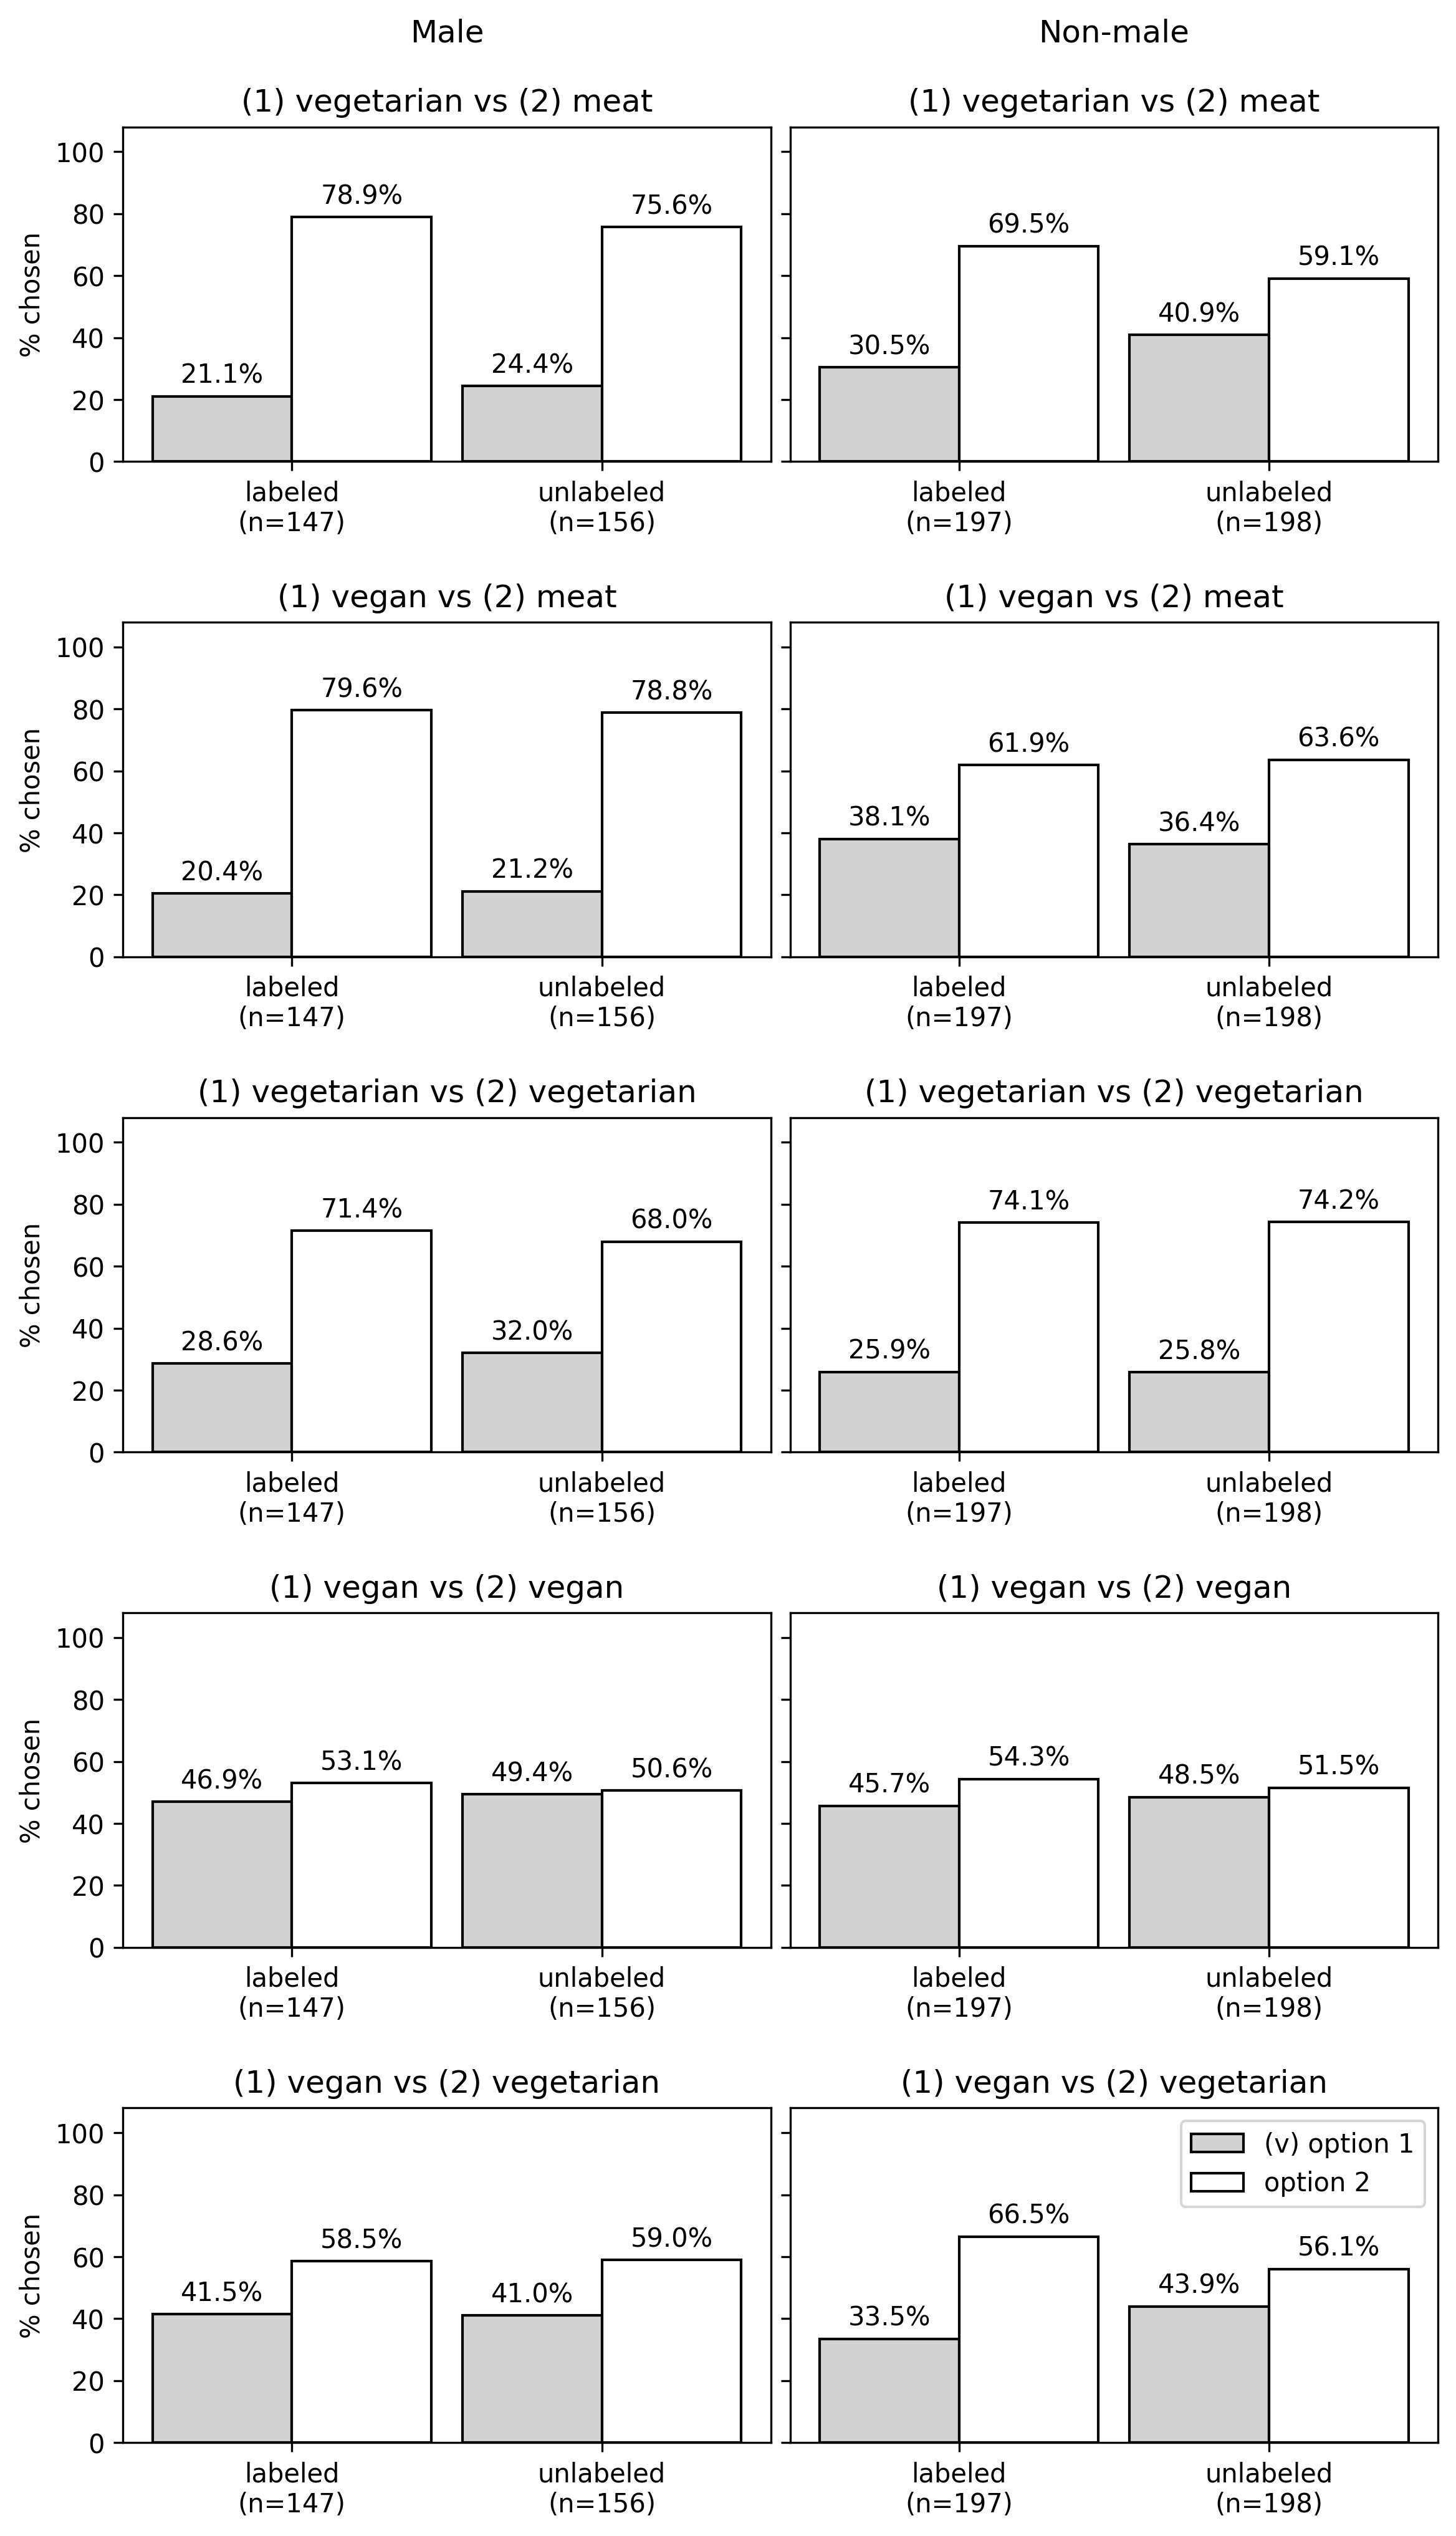

In [383]:
nrows=len(plot_choices_type_names_dict)
fig,axes = plt.subplots(
    nrows,2, figsize=(figsize[0]*2,2.7*nrows), sharey=True,
    dpi=300, 
    facecolor='white'
)
for i, (choice_type, name) in enumerate(plot_choices_type_names_dict.items()):
    cdf = choices_df[choices_df['choice_type']==choice_type]
    male_cdf = male_choices_df[male_choices_df['choice_type']==choice_type]
    nonmale_cdf = nonmale_choices_df[nonmale_choices_df['choice_type']==choice_type]
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.48, wspace=0.03)
    for j, (g, df) in enumerate([('Male',male_cdf),('Non-male', nonmale_cdf),]):
        ax = axes[i][j]
        ax.set_title(g)
        contingency_df = make_contingency_df(df)
        plot_df = plot_contingency_table(
            contingency_df, ax, 
            ylabel=(True if j==0 else False), legend=(True if (j>0 and i==4) else False)
        )
        title = ('%s\n\n%s' % (g, name)) if i==0 else name
        ax.set_title(title)
plt.show()

### Logistic Regressions


Just choice type 5 to double check this makes sense.
i.e. the OR matches above. It does.

In [329]:
eq = "choice ~ labeled"
choice_type_model = smf.logit(eq, data=c5df).fit()
display(choice_type_model.summary2())
choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
choice_type_model_odds['z-value'] = choice_type_model.pvalues
choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
print(choice_type_model_odds)

Optimization terminated successfully.
         Current function value: 0.670591
         Iterations 4


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
===============================================================
Model:              Logit            Pseudo R-squared: 0.003   
Dependent Variable: choice           AIC:              940.1446
Date:               2022-09-05 13:44 BIC:              949.2410
No. Observations:   698              Log-Likelihood:   -468.07 
Df Model:           1                LL-Null:          -469.27 
Df Residuals:       696              LLR p-value:      0.12149 
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     4.0000                                     
----------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
----------------------------------------------------------------
Intercept   -0.2959    0.1075  -2.7537  0.0059  -0.5066  -0.0853
labeled     -0.2398    0.1550  -1.5468  0.1219  -0.5436   0.0640
===============================================================

"""

                 OR   z-value      2.5%     97.5%
Intercept  0.743842  0.005892  0.602569  0.918237
labeled    0.786798  0.121911  0.580645  1.066143


In [330]:
# displaying / printing helpers
def get_predictors_table(model):
    return pd.DataFrame({
        'B (log odds)': model.params.apply(round, args=([3])),
        'Odds Ratio': np.exp(model.params).apply(round, args=([3])), 
        '95% CI for Odds Ratio': (
            np.exp(model.conf_int())
            .apply(lambda r: '[%0.3f, %0.3f]'%(r[0], r[1]), axis=1)
        ),
        'P-value': model.pvalues.apply(round, args=([3]))
    }).rename_axis('Predictor')

In [331]:
display(get_predictors_table(choice_type_model))

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-0.296,0.744,"[0.603, 0.918]",0.006
labeled,-0.240,0.787,"[0.581, 1.066]",0.122


For all choice types

In [335]:
predictors_tables = {} # to print for latex
for choice_type, name in choices_type_names_dict.items():
    print('%s: %s' % (choice_type, name))
    eq = "choice ~ labeled + male + labeled:male"
    cdf = choices_df[choices_df['choice_type']==choice_type]
    model = smf.logit(eq, data=cdf).fit()
    display(model.summary2())
    predictors_tables[choice_type] = get_predictors_table(model)
    display(get_predictors_table(model))

1: 1=(labeled) vegetarian vs 0=meat
Optimization terminated successfully.
         Current function value: 0.597962
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.022     
Dependent Variable: choice           AIC:              842.7544  
Date:               2022-09-05 14:13 BIC:              860.9473  
No. Observations:   698              Log-Likelihood:   -417.38   
Df Model:           3                LL-Null:          -426.89   
Df Residuals:       694              LLR p-value:      0.00026998
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -0.3677    0.1445  -2.5441  0.0110  -0.6510  -0.0844
labeled       -0.4579    0.2118  -2.1620  0.0306  -0.8730  -0.0428
male          -0.7654    0.2360  -3.2435  0.0012  -1.2279  -0.3029
labeled:male   0.2714    0.3472   0.7818  0.4344  -0.4090   0.9518
=================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-0.368,0.692,"[0.522, 0.919]",0.011
labeled,-0.458,0.633,"[0.418, 0.958]",0.031
male,-0.765,0.465,"[0.293, 0.739]",0.001
labeled:male,0.271,1.312,"[0.664, 2.590]",0.434


2: 1=(labeled) vegan vs 0=meat
Optimization terminated successfully.
         Current function value: 0.595346
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.027     
Dependent Variable: choice           AIC:              839.1036  
Date:               2022-09-05 14:13 BIC:              857.2964  
No. Observations:   698              Log-Likelihood:   -415.55   
Df Model:           3                LL-Null:          -426.89   
Df Residuals:       694              LLR p-value:      4.7146e-05
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -0.5596    0.1477  -3.7880  0.0002  -0.8492  -0.2701
labeled        0.0731    0.2082   0.3510  0.7256  -0.3350   0.4812
male          -0.7561    0.2455  -3.0800  0.0021  -1.2372  -0.2749
labeled:male  -0.1184    0.3517  -0.3366  0.7364  -0.8076   0.5709
=================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-0.560,0.571,"[0.428, 0.763]",0.000
labeled,0.073,1.076,"[0.715, 1.618]",0.726
male,-0.756,0.470,"[0.290, 0.760]",0.002
labeled:male,-0.118,0.888,"[0.446, 1.770]",0.736


3: 1=(labeled) vegetarian vs 0=vegetarian
Optimization terminated successfully.
         Current function value: 0.589426
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
===============================================================
Model:              Logit            Pseudo R-squared: 0.003   
Dependent Variable: choice           AIC:              830.8382
Date:               2022-09-05 14:13 BIC:              849.0311
No. Observations:   698              Log-Likelihood:   -411.42 
Df Model:           3                LL-Null:          -412.51 
Df Residuals:       694              LLR p-value:      0.53396 
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     5.0000                                     
---------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept       -1.0586   0.1625 -6.5140 0.0000 -1.3771 -0.7401
labeled          0.0068   0.2299  0.0297 0.9763 -0.4438  0.4575
male             0.3072   0.2363  1.2999 0.1936 -0.1560  0.7704
labeled:male    -0.1717   0.3401 -0.5049 0.6136 -0.8382  0.4948
===============================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-1.059,0.347,"[0.252, 0.477]",0.000
labeled,0.007,1.007,"[0.642, 1.580]",0.976
male,0.307,1.360,"[0.856, 2.161]",0.194
labeled:male,-0.172,0.842,"[0.432, 1.640]",0.614


4: 1=(labeled) vegan vs 0=vegan
Optimization terminated successfully.
         Current function value: 0.691551
         Iterations 3


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
===============================================================
Model:              Logit            Pseudo R-squared: 0.001   
Dependent Variable: choice           AIC:              973.4058
Date:               2022-09-05 14:13 BIC:              991.5987
No. Observations:   698              Log-Likelihood:   -482.70 
Df Model:           3                LL-Null:          -482.99 
Df Residuals:       694              LLR p-value:      0.90307 
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     3.0000                                     
---------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
---------------------------------------------------------------
Intercept        -0.0606   0.1422 -0.4263 0.6699 -0.3393 0.2181
labeled          -0.1124   0.2017 -0.5573 0.5773 -0.5077 0.2829
male              0.0350   0.2142  0.1633 0.8702 -0.3848 0.4547
labeled:male      0.0154   0.3060  0.0504 0.9598 -0.5843 0.6152
===============================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-0.061,0.941,"[0.712, 1.244]",0.670
labeled,-0.112,0.894,"[0.602, 1.327]",0.577
male,0.035,1.036,"[0.681, 1.576]",0.870
labeled:male,0.015,1.016,"[0.557, 1.850]",0.960


5: 1=(labeled) vegan vs 0=vegetarian
Optimization terminated successfully.
         Current function value: 0.668723
         Iterations 4


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
===============================================================
Model:              Logit            Pseudo R-squared: 0.005   
Dependent Variable: choice           AIC:              941.5379
Date:               2022-09-05 14:13 BIC:              959.7308
No. Observations:   698              Log-Likelihood:   -466.77 
Df Model:           3                LL-Null:          -469.27 
Df Residuals:       694              LLR p-value:      0.17146 
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     4.0000                                     
---------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept       -0.2436   0.1432 -1.7014 0.0889 -0.5243  0.0370
labeled         -0.4419   0.2081 -2.1240 0.0337 -0.8497 -0.0341
male            -0.1193   0.2168 -0.5502 0.5822 -0.5442  0.3056
labeled:male     0.4614   0.3127  1.4752 0.1402 -0.1516  1.0743
===============================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-0.244,0.784,"[0.592, 1.038]",0.089
labeled,-0.442,0.643,"[0.428, 0.966]",0.034
male,-0.119,0.888,"[0.580, 1.357]",0.582
labeled:male,0.461,1.586,"[0.859, 2.928]",0.140


In [336]:
for choice_type, table in predictors_tables.items():
    print(choice_type)
    print(table.to_latex())

1
\begin{tabular}{lrrlr}
\toprule
{} &  B (log odds) &  Odds Ratio & 95\% CI for Odds Ratio &  P-value \\
Predictor    &               &             &                       &          \\
\midrule
Intercept    &        -0.368 &       0.692 &        [0.522, 0.919] &    0.011 \\
labeled      &        -0.458 &       0.633 &        [0.418, 0.958] &    0.031 \\
male         &        -0.765 &       0.465 &        [0.293, 0.739] &    0.001 \\
labeled:male &         0.271 &       1.312 &        [0.664, 2.590] &    0.434 \\
\bottomrule
\end{tabular}

2
\begin{tabular}{lrrlr}
\toprule
{} &  B (log odds) &  Odds Ratio & 95\% CI for Odds Ratio &  P-value \\
Predictor    &               &             &                       &          \\
\midrule
Intercept    &        -0.560 &       0.571 &        [0.428, 0.763] &    0.000 \\
labeled      &         0.073 &       1.076 &        [0.715, 1.618] &    0.726 \\
male         &        -0.756 &       0.470 &        [0.290, 0.760] &    0.002 \\
labeled:male &

Control for demographic covariates (age & income)

In [332]:
# controlling for demographic covariates
for choice_type, name in choices_type_names_dict.items():
    print('%s: %s' % (choice_type, name))
    eq = "choice ~ labeled + male + labeled:male + age + income"
    cdf = choices_df[choices_df['choice_type']==choice_type]
    model = smf.logit(eq, data=cdf).fit()
    display(model.summary2())
    model_odds = display(get_predictors_table(model))

1: 1=(labeled) vegetarian vs 0=meat
Optimization terminated successfully.
         Current function value: 0.590297
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.035    
Dependent Variable: choice           AIC:              854.0552 
Date:               2022-09-05 13:45 BIC:              922.2785 
No. Observations:   698              Log-Likelihood:   -412.03  
Df Model:           14               LL-Null:          -426.89  
Df Residuals:       683              LLR p-value:      0.0083237
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
----------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------
Intercept        -0.3778   0.2929 -1.2899 0.1971 -0.9519  0.1963
age[T.3]         -0.1082   0.2249 -0.4810 0.6305 -0.5489  0.3326
age[T.4]         -0.1787   0.2673 -0.6688 0.5037 -0.7025  0.3451
age[T.5]         -0.3273   0.3297 -0.9927 0.3208 -0.9736  0.3189
age[T.6]         -0.1322   0.3782 -0.3495 0.7267 -0.8734  0.6090
age[T.7]          0.3887   0.4160  0.9344 0.3501 -0.4266  1.2041
income[T.2]      -0.0318   0.3132 -0.1014 0.9192 -0.6457  0.5821
income[T.3]       0.0618   0.3174  0.1947 0.8457 -0.5603  0.6839
income[T.4]       0.4910   0.3169  1.5493 0.1213 -0.1301  1.1121
income[T.5]      -0.2127   0.3356 -0.6337 0.5263 -0.8704  0.4451
income[T.6]       0.3679   0.3474  1.0591 0.2896 -0.3130  1.0488
income[T.7]      -0.3790   0.5334 -0.7104 0.4774 -1.4245  0.6665
labeled          -0.4131   0.2145 -1.9262 0.0541 -0.8335  0.0072
male             -0.7837   0.2420 -3.2381 0.0012 -1.2581 -0.3094
labeled:male      0.2423   0.3532  0.6861 0.4927 -0.4499  0.9346
================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-0.378,0.685,"[0.386, 1.217]",0.197
age[T.3],-0.108,0.897,"[0.578, 1.395]",0.631
age[T.4],-0.179,0.836,"[0.495, 1.412]",0.504
age[T.5],-0.327,0.721,"[0.378, 1.376]",0.321
age[T.6],-0.132,0.876,"[0.418, 1.839]",0.727
age[T.7],0.389,1.475,"[0.653, 3.334]",0.350
income[T.2],-0.032,0.969,"[0.524, 1.790]",0.919
income[T.3],0.062,1.064,"[0.571, 1.982]",0.846
income[T.4],0.491,1.634,"[0.878, 3.041]",0.121


2: 1=(labeled) vegan vs 0=meat
Optimization terminated successfully.
         Current function value: 0.581085
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.050     
Dependent Variable: choice           AIC:              841.1943  
Date:               2022-09-05 13:45 BIC:              909.4176  
No. Observations:   698              Log-Likelihood:   -405.60   
Df Model:           14               LL-Null:          -426.89   
Df Residuals:       683              LLR p-value:      9.9732e-05
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.1094    0.3123  -3.5526  0.0004  -1.7214  -0.4973
age[T.3]       0.1678    0.2379   0.7054  0.4806  -0.2984   0.6340
age[T.4]       0.4240    0.2719   1.5593  0.1189  -0.1090   0.9570
age[T.5]       0.6324    0.3188   1.9833  0.0473   0.0074   1.2573
age[T.6]       1.0956    0.3624   3.0229  0.0025   0.3852   1.8059
age[T.7]       1.0574    0.4187   2.5255  0.0116   0.2368   1.8781
income[T.2]    0.3324    0.3218   1.0327  0.3017  -0.2984   0.9631
income[T.3]    0.2332    0.3276   0.7117  0.4767  -0.4090   0.8753
income[T.4]    0.3974    0.3330   1.1932  0.2328  -0.2554   1.0501
income[T.5]    0.2080    0.3377   0.6158  0.5380  -0.4539   0.8698
income[T.6]    0.3819    0.3625   1.0535  0.2921  -0.3286   1.0923
income[T.7]   -0.2592    0.5689  -0.4557  0.6486  -1.3744   0.8559
labeled        0.0914    0.2130   0.4294  0.6676  -0.3260   0.5089
male          -0.8628    0.2535  -3.4039  0.0007  -1.3596  -0.3660
labeled:male  -0.1670    0.3601  -0.4637  0.6429  -0.8728   0.5388
=================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-1.109,0.330,"[0.179, 0.608]",0.000
age[T.3],0.168,1.183,"[0.742, 1.885]",0.481
age[T.4],0.424,1.528,"[0.897, 2.604]",0.119
age[T.5],0.632,1.882,"[1.007, 3.516]",0.047
age[T.6],1.096,2.991,"[1.470, 6.085]",0.003
age[T.7],1.057,2.879,"[1.267, 6.541]",0.012
income[T.2],0.332,1.394,"[0.742, 2.620]",0.302
income[T.3],0.233,1.263,"[0.664, 2.400]",0.477
income[T.4],0.397,1.488,"[0.775, 2.858]",0.233


3: 1=(labeled) vegetarian vs 0=vegetarian
Optimization terminated successfully.
         Current function value: 0.583133
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
===============================================================
Model:              Logit            Pseudo R-squared: 0.013   
Dependent Variable: choice           AIC:              844.0531
Date:               2022-09-05 13:45 BIC:              912.2764
No. Observations:   698              Log-Likelihood:   -407.03 
Df Model:           14               LL-Null:          -412.51 
Df Residuals:       683              LLR p-value:      0.68801 
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     5.0000                                     
---------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept       -1.1344   0.3061 -3.7066 0.0002 -1.7343 -0.5346
age[T.3]         0.3695   0.2345  1.5760 0.1150 -0.0900  0.8291
age[T.4]         0.0277   0.2831  0.0979 0.9220 -0.5272  0.5826
age[T.5]         0.0368   0.3352  0.1099 0.9125 -0.6201  0.6938
age[T.6]         0.1425   0.3894  0.3660 0.7143 -0.6206  0.9056
age[T.7]         0.9474   0.4091  2.3158 0.0206  0.1456  1.7493
income[T.2]     -0.3020   0.3156 -0.9569 0.3386 -0.9206  0.3166
income[T.3]     -0.1336   0.3184 -0.4196 0.6748 -0.7576  0.4904
income[T.4]      0.0016   0.3209  0.0051 0.9959 -0.6273  0.6306
income[T.5]     -0.1645   0.3293 -0.4996 0.6173 -0.8099  0.4809
income[T.6]     -0.0166   0.3528 -0.0470 0.9626 -0.7081  0.6750
income[T.7]      0.1224   0.4947  0.2474 0.8046 -0.8472  1.0920
labeled          0.0020   0.2323  0.0085 0.9932 -0.4534  0.4573
male             0.2514   0.2417  1.0400 0.2983 -0.2224  0.7251
labeled:male    -0.1476   0.3458 -0.4268 0.6695 -0.8253  0.5301
===============================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-1.134,0.322,"[0.177, 0.586]",0.000
age[T.3],0.370,1.447,"[0.914, 2.291]",0.115
age[T.4],0.028,1.028,"[0.590, 1.791]",0.922
age[T.5],0.037,1.038,"[0.538, 2.001]",0.913
age[T.6],0.143,1.153,"[0.538, 2.474]",0.714
age[T.7],0.947,2.579,"[1.157, 5.751]",0.021
income[T.2],-0.302,0.739,"[0.398, 1.372]",0.339
income[T.3],-0.134,0.875,"[0.469, 1.633]",0.675
income[T.4],0.002,1.002,"[0.534, 1.879]",0.996


4: 1=(labeled) vegan vs 0=vegan
Optimization terminated successfully.
         Current function value: 0.687247
         Iterations 4


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.007    
Dependent Variable: choice           AIC:              989.3966 
Date:               2022-09-05 13:45 BIC:              1057.6199
No. Observations:   698              Log-Likelihood:   -479.70  
Df Model:           14               LL-Null:          -482.99  
Df Residuals:       683              LLR p-value:      0.94969  
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     4.0000                                      
-----------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
-----------------------------------------------------------------
Intercept     -0.2021    0.2718  -0.7434  0.4572  -0.7349  0.3307
age[T.3]      -0.0234    0.2069  -0.1130  0.9100  -0.4289  0.3821
age[T.4]       0.0687    0.2431   0.2826  0.7775  -0.4078  0.5451
age[T.5]       0.2320    0.2896   0.8011  0.4231  -0.3357  0.7997
age[T.6]       0.3874    0.3434   1.1281  0.2593  -0.2856  1.0605
age[T.7]       0.2634    0.3939   0.6687  0.5037  -0.5086  1.0353
income[T.2]    0.0692    0.2811   0.2460  0.8057  -0.4819  0.6202
income[T.3]    0.0878    0.2872   0.3056  0.7599  -0.4751  0.6506
income[T.4]   -0.0293    0.2923  -0.1001  0.9202  -0.6022  0.5436
income[T.5]    0.3699    0.2951   1.2534  0.2100  -0.2085  0.9484
income[T.6]   -0.0437    0.3199  -0.1365  0.8915  -0.6707  0.5834
income[T.7]    0.2535    0.4532   0.5595  0.5758  -0.6347  1.1418
labeled       -0.1331    0.2036  -0.6540  0.5131  -0.5321  0.2658
male           0.0145    0.2186   0.0664  0.9471  -0.4139  0.4429
labeled:male   0.0398    0.3106   0.1281  0.8981  -0.5689  0.6485
================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-0.202,0.817,"[0.480, 1.392]",0.457
age[T.3],-0.023,0.977,"[0.651, 1.465]",0.910
age[T.4],0.069,1.071,"[0.665, 1.725]",0.778
age[T.5],0.232,1.261,"[0.715, 2.225]",0.423
age[T.6],0.387,1.473,"[0.752, 2.888]",0.259
age[T.7],0.263,1.301,"[0.601, 2.816]",0.504
income[T.2],0.069,1.072,"[0.618, 1.859]",0.806
income[T.3],0.088,1.092,"[0.622, 1.917]",0.760
income[T.4],-0.029,0.971,"[0.548, 1.722]",0.920


5: 1=(labeled) vegan vs 0=vegetarian
Optimization terminated successfully.
         Current function value: 0.655661
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.025    
Dependent Variable: choice           AIC:              945.3031 
Date:               2022-09-05 13:45 BIC:              1013.5264
No. Observations:   698              Log-Likelihood:   -457.65  
Df Model:           14               LL-Null:          -469.27  
Df Residuals:       683              LLR p-value:      0.056484 
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
----------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------
Intercept        -0.6657   0.2871 -2.3190 0.0204 -1.2284 -0.1031
age[T.3]         -0.0463   0.2164 -0.2138 0.8307 -0.4704  0.3779
age[T.4]          0.1600   0.2511  0.6374 0.5239 -0.3321  0.6521
age[T.5]          0.5330   0.2948  1.8079 0.0706 -0.0448  1.1108
age[T.6]          0.8943   0.3501  2.5548 0.0106  0.2082  1.5804
age[T.7]          0.6070   0.3986  1.5227 0.1278 -0.1743  1.3882
income[T.2]       0.1525   0.2985  0.5108 0.6095 -0.4326  0.7376
income[T.3]       0.5403   0.3013  1.7931 0.0730 -0.0503  1.1308
income[T.4]       0.3301   0.3066  1.0766 0.2817 -0.2708  0.9309
income[T.5]       0.1820   0.3117  0.5840 0.5592 -0.4289  0.7929
income[T.6]       0.2831   0.3347  0.8460 0.3976 -0.3728  0.9390
income[T.7]       0.7124   0.4646  1.5333 0.1252 -0.1982  1.6230
labeled          -0.4553   0.2120 -2.1481 0.0317 -0.8707 -0.0399
male             -0.1353   0.2236 -0.6050 0.5452 -0.5736  0.3030
labeled:male      0.4349   0.3202  1.3582 0.1744 -0.1927  1.0625
================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,-0.666,0.514,"[0.293, 0.902]",0.020
age[T.3],-0.046,0.955,"[0.625, 1.459]",0.831
age[T.4],0.160,1.174,"[0.717, 1.920]",0.524
age[T.5],0.533,1.704,"[0.956, 3.037]",0.071
age[T.6],0.894,2.446,"[1.232, 4.857]",0.011
age[T.7],0.607,1.835,"[0.840, 4.008]",0.128
income[T.2],0.152,1.165,"[0.649, 2.091]",0.610
income[T.3],0.540,1.716,"[0.951, 3.098]",0.073
income[T.4],0.330,1.391,"[0.763, 2.537]",0.282


## Comments

The survey comments are fun to read. And informative.

High level notes:
- people do not like onions
- some people do not like olives and pointed out that the vegan/vegetarian options had more olives
- some people did not like any of the menu options
- people did not appreciate that political spectrum was presented on a democrat to republican scale
- many people enjoyed/appreciated the study and said so.
- some people enjoyed the roasted attention check

In [363]:
comments_by_gender = respondent_df.set_index('gender')['Q_comments'].dropna()
print('%s total comments:\n' % len(comments_by_gender))
for gender, comment in comments_by_gender.items():
    print('[%s] "%s"\n' % (gender, comment))

90 total comments:

[Male] "I do not lean toward either party. I am a libertarian. Unfortunately, your survey doesn't treat libertarians as if they exist at all."

[Female] "None, but thank you!"

[Male] "ty"

[Male] "no"

[Male] "No thanks! "

[Male] "Enjoyed the study!"

[Male] "In a complex economy vegetarian or "vegan" options are only beneficial if they are produced locally. Since many of us live in climates that do not support year round vegetable agriculture that means most of what veggies consume is from somewhere far away and probably in a place lacking in water. Also, there are far more options than Democrat and Republican. Two sides of the same capitalist coin are not a democracy and the cause of much of the worlds problems."

[Male] "Thank you for the study, I answered honestly and to the best of my abilities."

[Female] "No"

[Male] "could have used a few more attention checks... jk."

[Male] "Hope I was helpful"

[Female] "No"

[Female] "None "

[Female] "Enjoyed the surv